In [1]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import pickle

from emgdecompy.preprocessing import * 
from functions import *
from realtime_decomp import *

# Tibialis anterior 35% MVC
ta_35 = loadmat('./data/experimental_data_raw/ta_35.mat')['SIG']
ta_35_0 = loadmat('./data/experimental_data_raw/ta_35_0.mat')['SIG']

indpt_ta35_pnr = loadmat('./data/experimental_data_raw/ta_35.mat')['MUPulses']
indpt_ta35_0_pnr = loadmat('./data/experimental_data_raw/ta_35_0.mat')['MUPulses']

ref_ta35_pnr = loadmat('./data/experimental_data_raw/ta_35.mat')['ref_signal']
ref_ta35_0_pnr = loadmat('./data/experimental_data_raw/ta_35_0.mat')['ref_signal']

with open('./data/decomp_ta_35.obj', 'rb') as f: decomp_ta35 = pickle.load(f)
with open('./data/decomp_ta35_x47_x57_x58.obj', 'rb') as f: decomp_ta35_x47_x57_x58 = pickle.load(f)

In [2]:
data = ta_35
signal = "ta_35"
ref_signal = ref_ta35_pnr
batch_size = 4.0
noise_start = 0.0
noise_end = 3.0
ol=[1.0, 2.0, 3.0]

bad_ch = bad_channels(data, signal=signal, thd_snr=2.0, 
                      noise_start=noise_start, noise_end=noise_end, fs=2048)
snr = calc_snr(data, 
               noise_start=noise_start, noise_end=noise_end, fs=2048)

disc_ch = loadmat('./data/experimental_data_raw/ta_35.mat')['discardChannelsVec']
disc_ch_0 = loadmat('./data/experimental_data_raw/ta_35_0.mat')['discardChannelsVec']


disc_ch_flat = discard_ch_flat(disc_ch, ta_35)
print(disc_ch_flat)
print(np.argwhere(disc_ch_flat == 1))

Bad channels in ta_35: []
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0]
[[47]
 [57]
 [58]]


# a. Training Module
## i. Decomposition

In [3]:
decomp = decomp_ta35

In [5]:
decomp_ta35_x47_x57_x58 = decomposition_tmod(x=data,
                            discard=disc_ch_flat,
                            R=16,
                            M=64,
                            bandpass=True,
                            lowcut=10,
                            highcut = 900,
                            fs=2048,
                            order=6,
                            Tolx=10e-4,
                            contrast_fun=skew,
                            ortho_fun=gram_schmidt,
                            max_iter_sep=10,
                            l=31,
                            sil_pnr=True,
                            thresh=0.9,
                            max_iter_ref=10,
                            random_seed=None,
                            verbose=False)

Centred.
Extended.
Whitened.
Extracted source at iteration 7.
Extracted source at iteration 28.
Extracted source at iteration 45.
Extracted source at iteration 49.
Extracted source at iteration 61.


In [6]:
decomp_sample = decomp_ta35_x47_x57_x58 
decomp_sample_pkl = open('decomp_ta35_x47_x57_x58.obj', 'wb') 
pickle.dump(decomp_sample, decomp_sample_pkl)

In [7]:
decomp_ta35_tmod = decomposition_tmod(x=data,
                            discard=None,
                            R=16,
                            M=64,
                            bandpass=True,
                            lowcut=10,
                            highcut = 900,
                            fs=2048,
                            order=6,
                            Tolx=10e-4,
                            contrast_fun=skew,
                            ortho_fun=gram_schmidt,
                            max_iter_sep=10,
                            l=31,
                            sil_pnr=True,
                            thresh=0.9,
                            max_iter_ref=10,
                            random_seed=None,
                            verbose=False)

Centred.
Extended.
Whitened.
Extracted source at iteration 8.
Extracted source at iteration 26.
Extracted source at iteration 43.
Extracted source at iteration 51.


In [8]:
decomp_sample = decomp_ta35_tmod 
decomp_sample_pkl = open('decomp_ta35_tmod.obj', 'wb') 
pickle.dump(decomp_sample, decomp_sample_pkl)

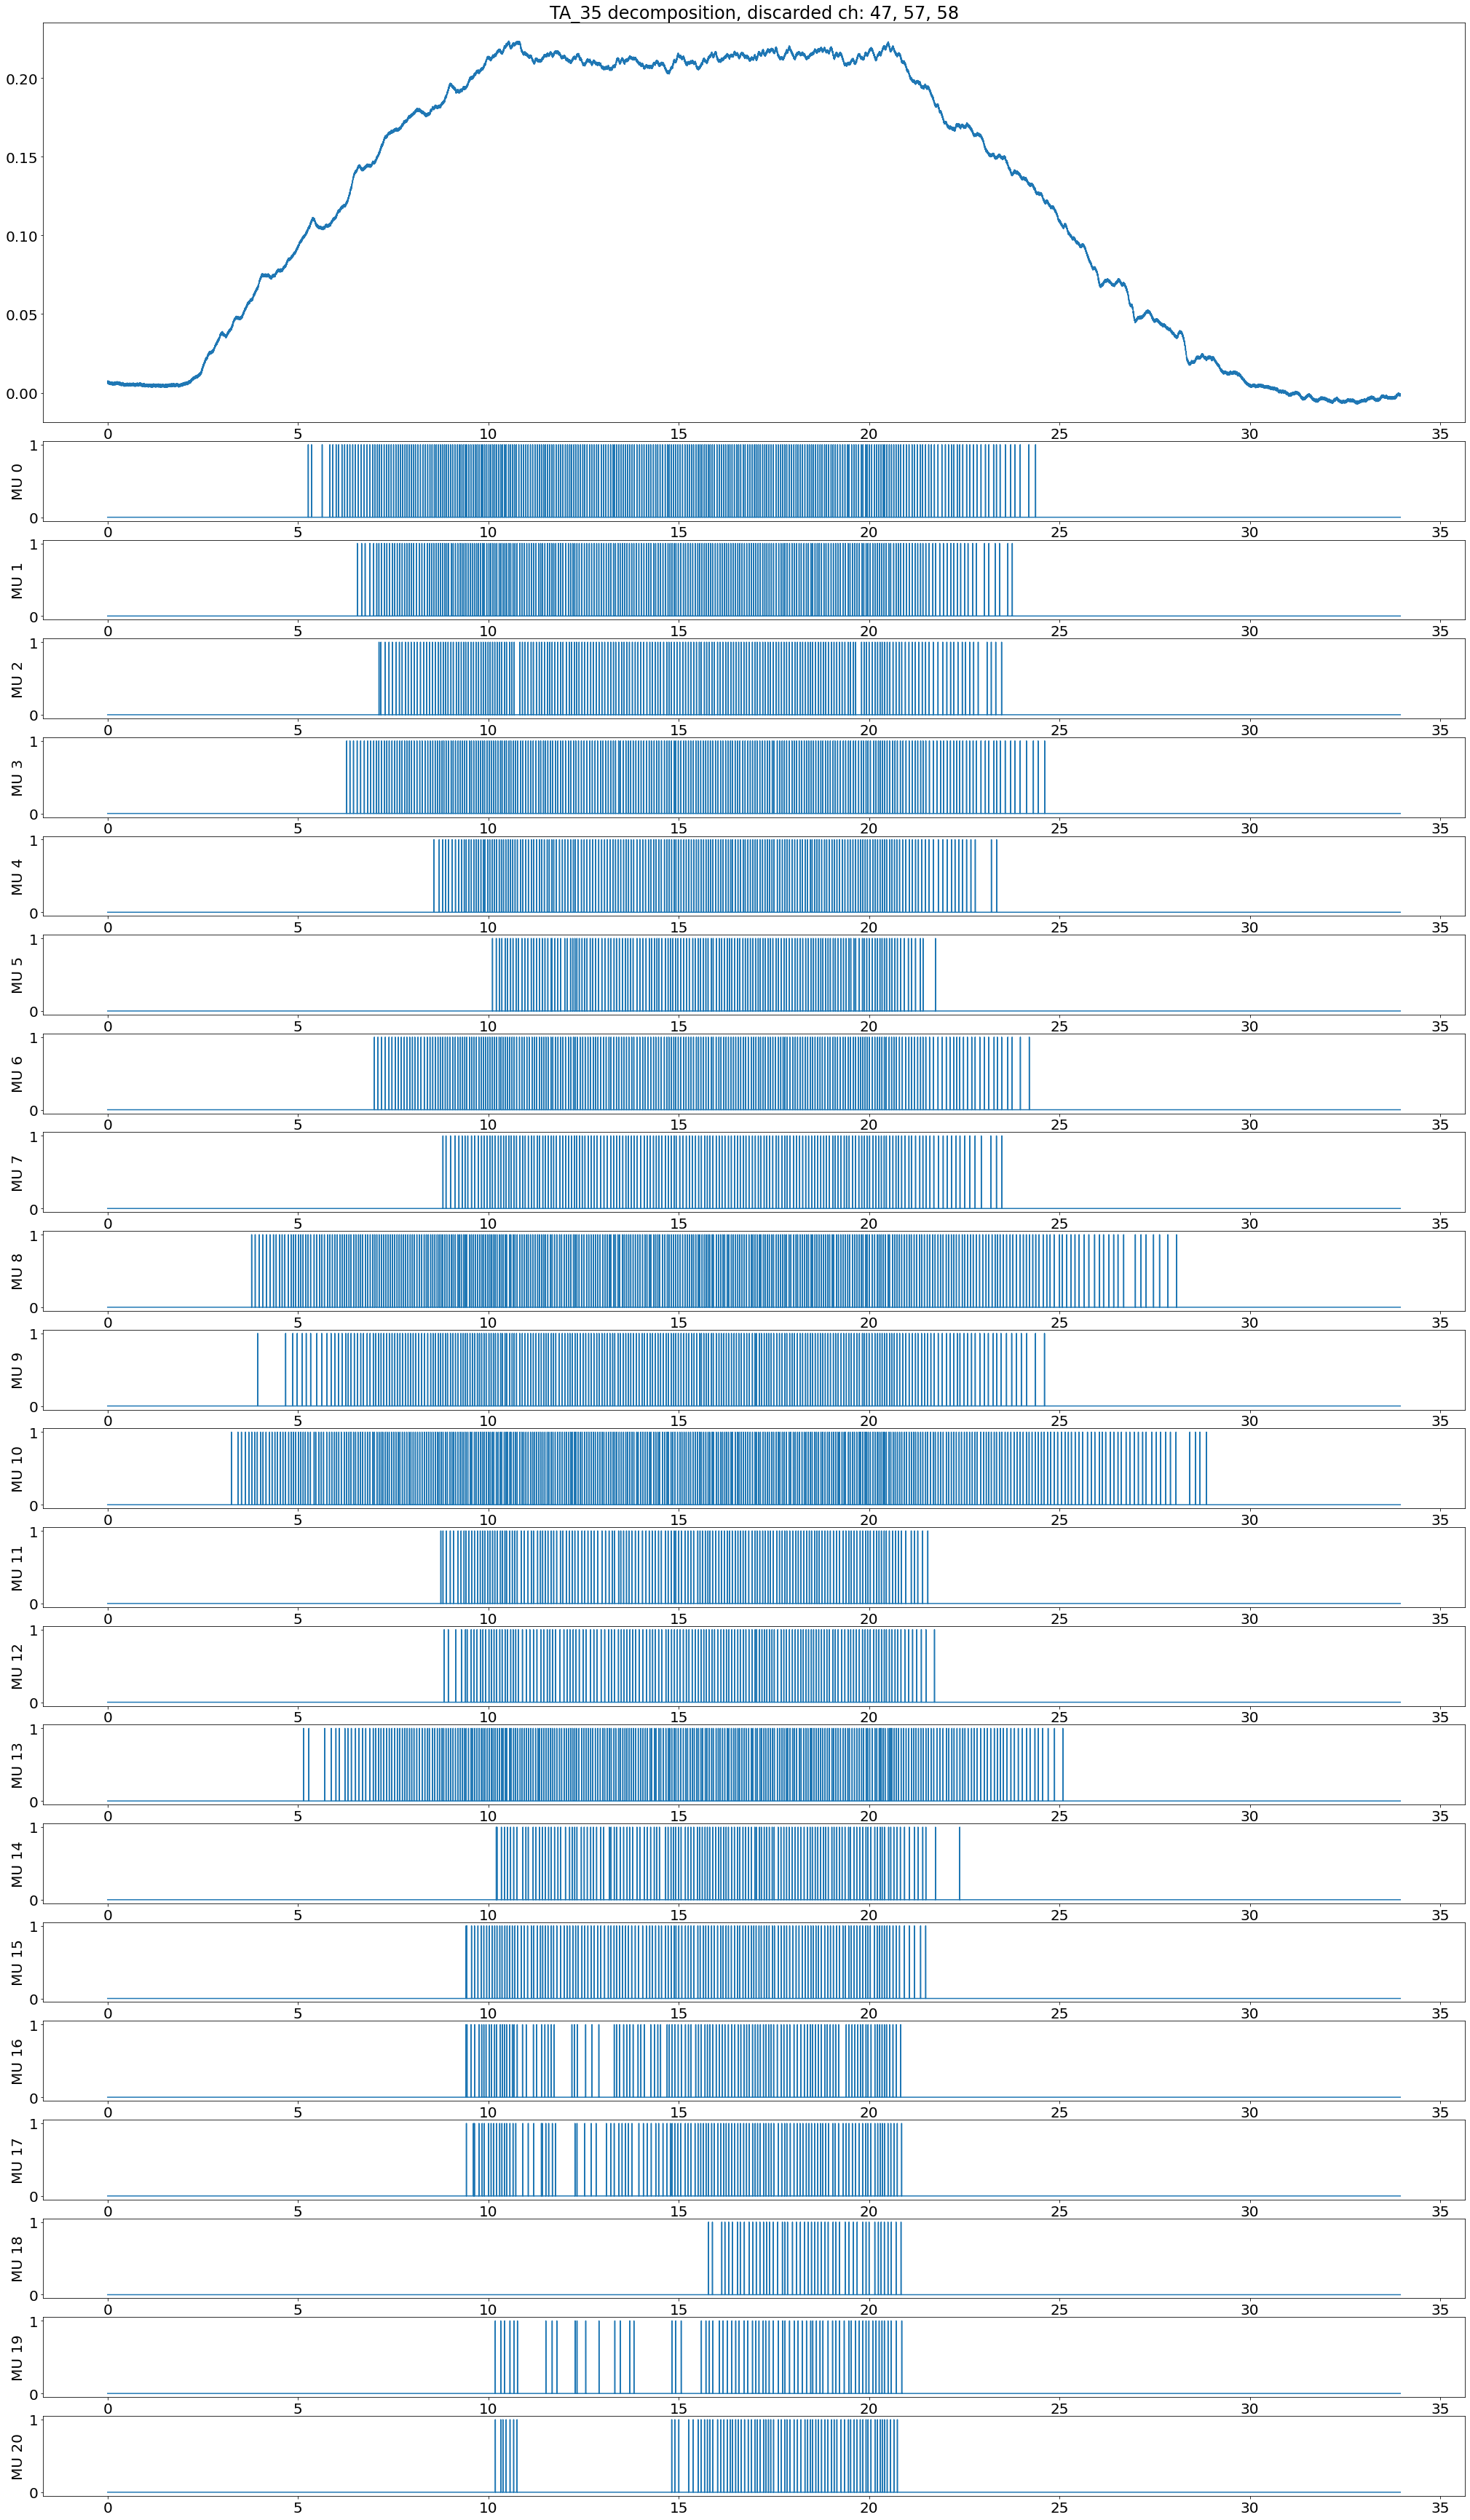

In [37]:
visualize_pt(indpt_ta35_pnr, 
             data, ref_signal=ref_signal, title="TA_35 decomposition, discarded ch: 47, 57, 58")

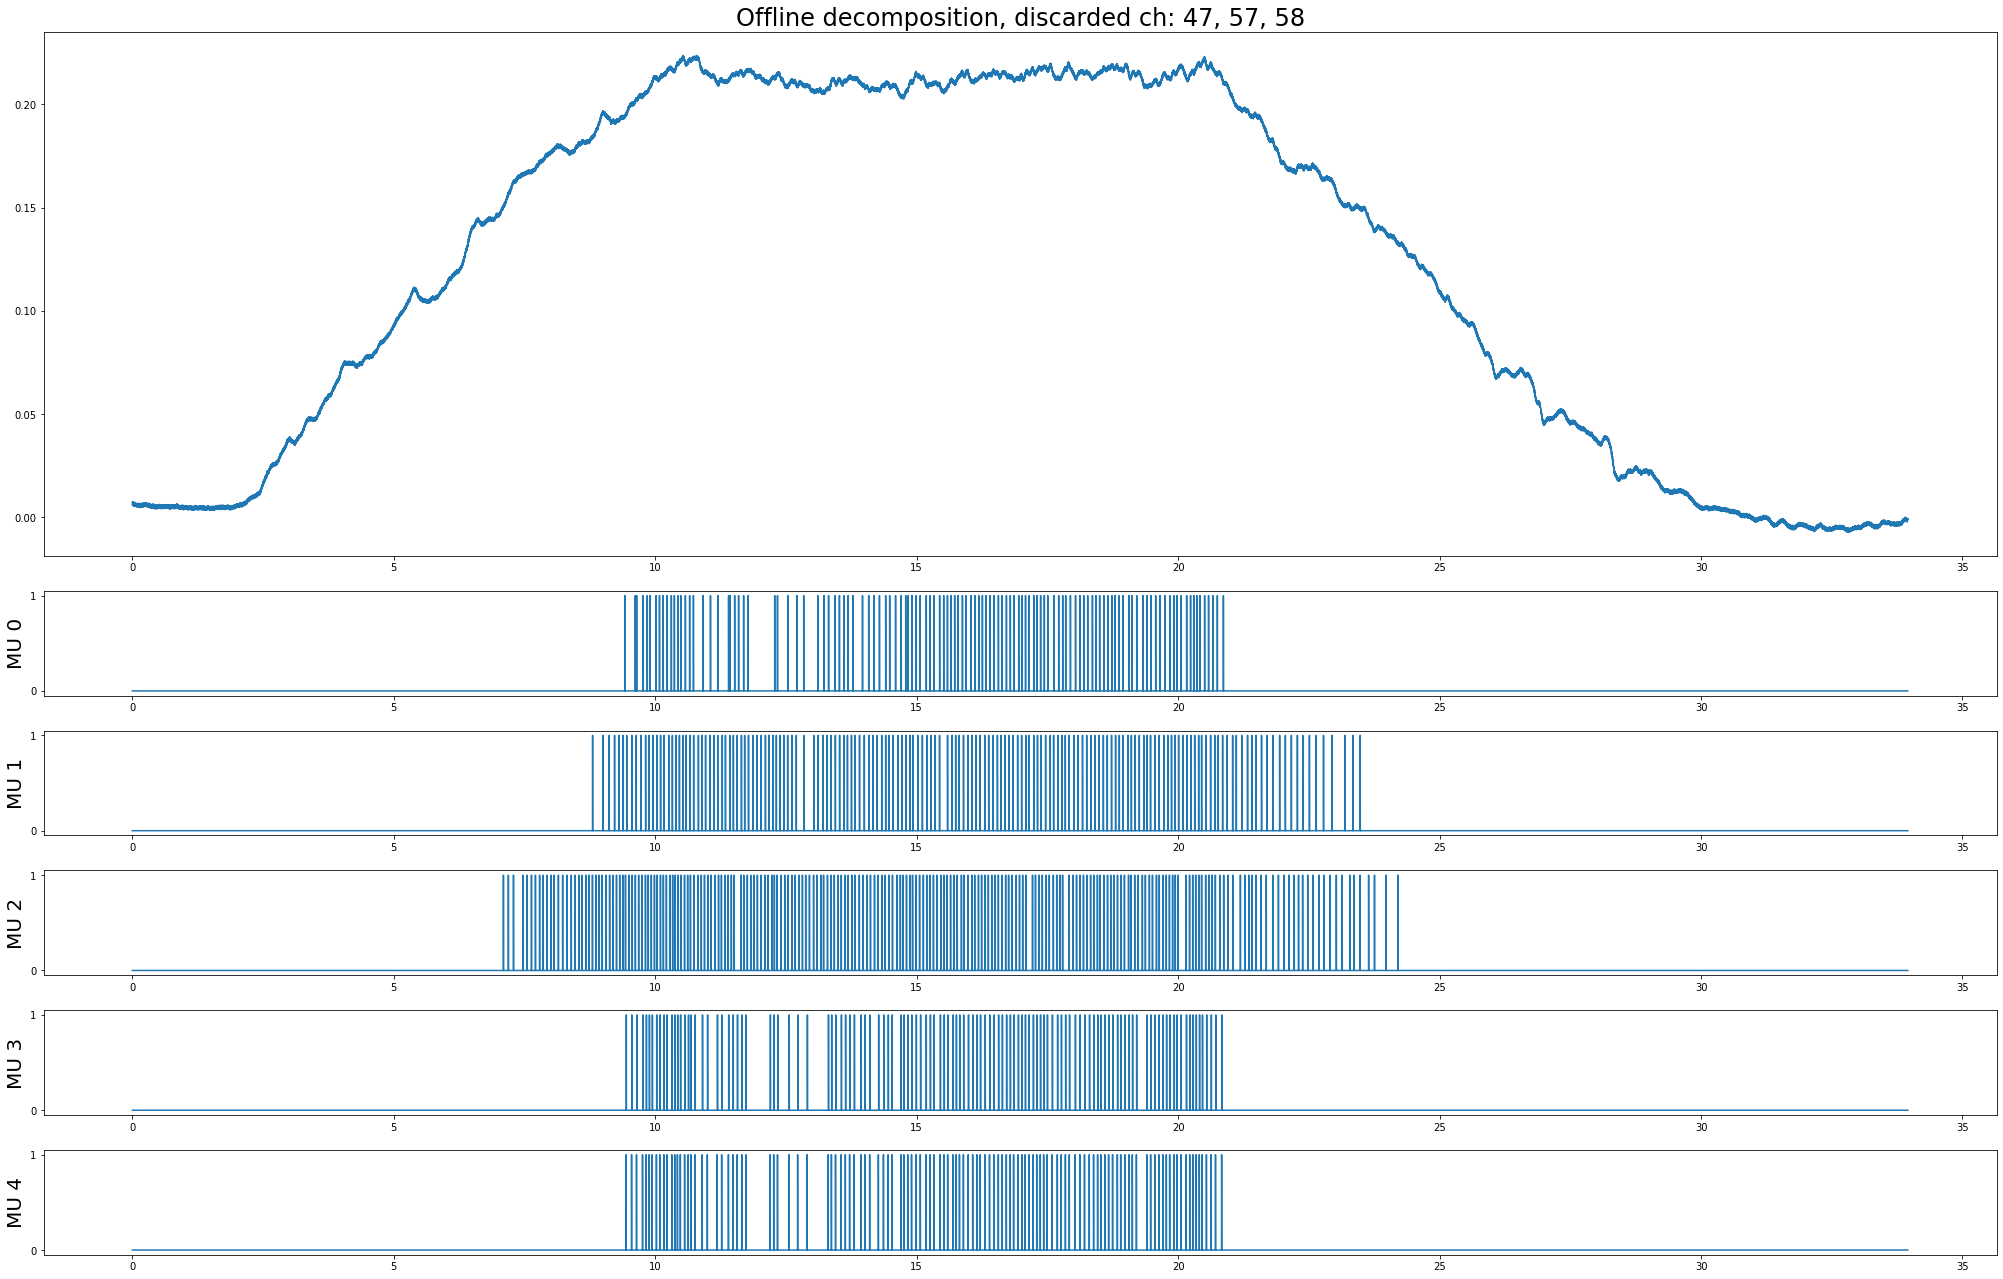

In [9]:
visualize_pt(decomp_ta35_x47_x57_x58["MUPulses"], 
             data, ref_signal=ref_signal, title="Offline decomposition, discarded ch: 47, 57, 58")

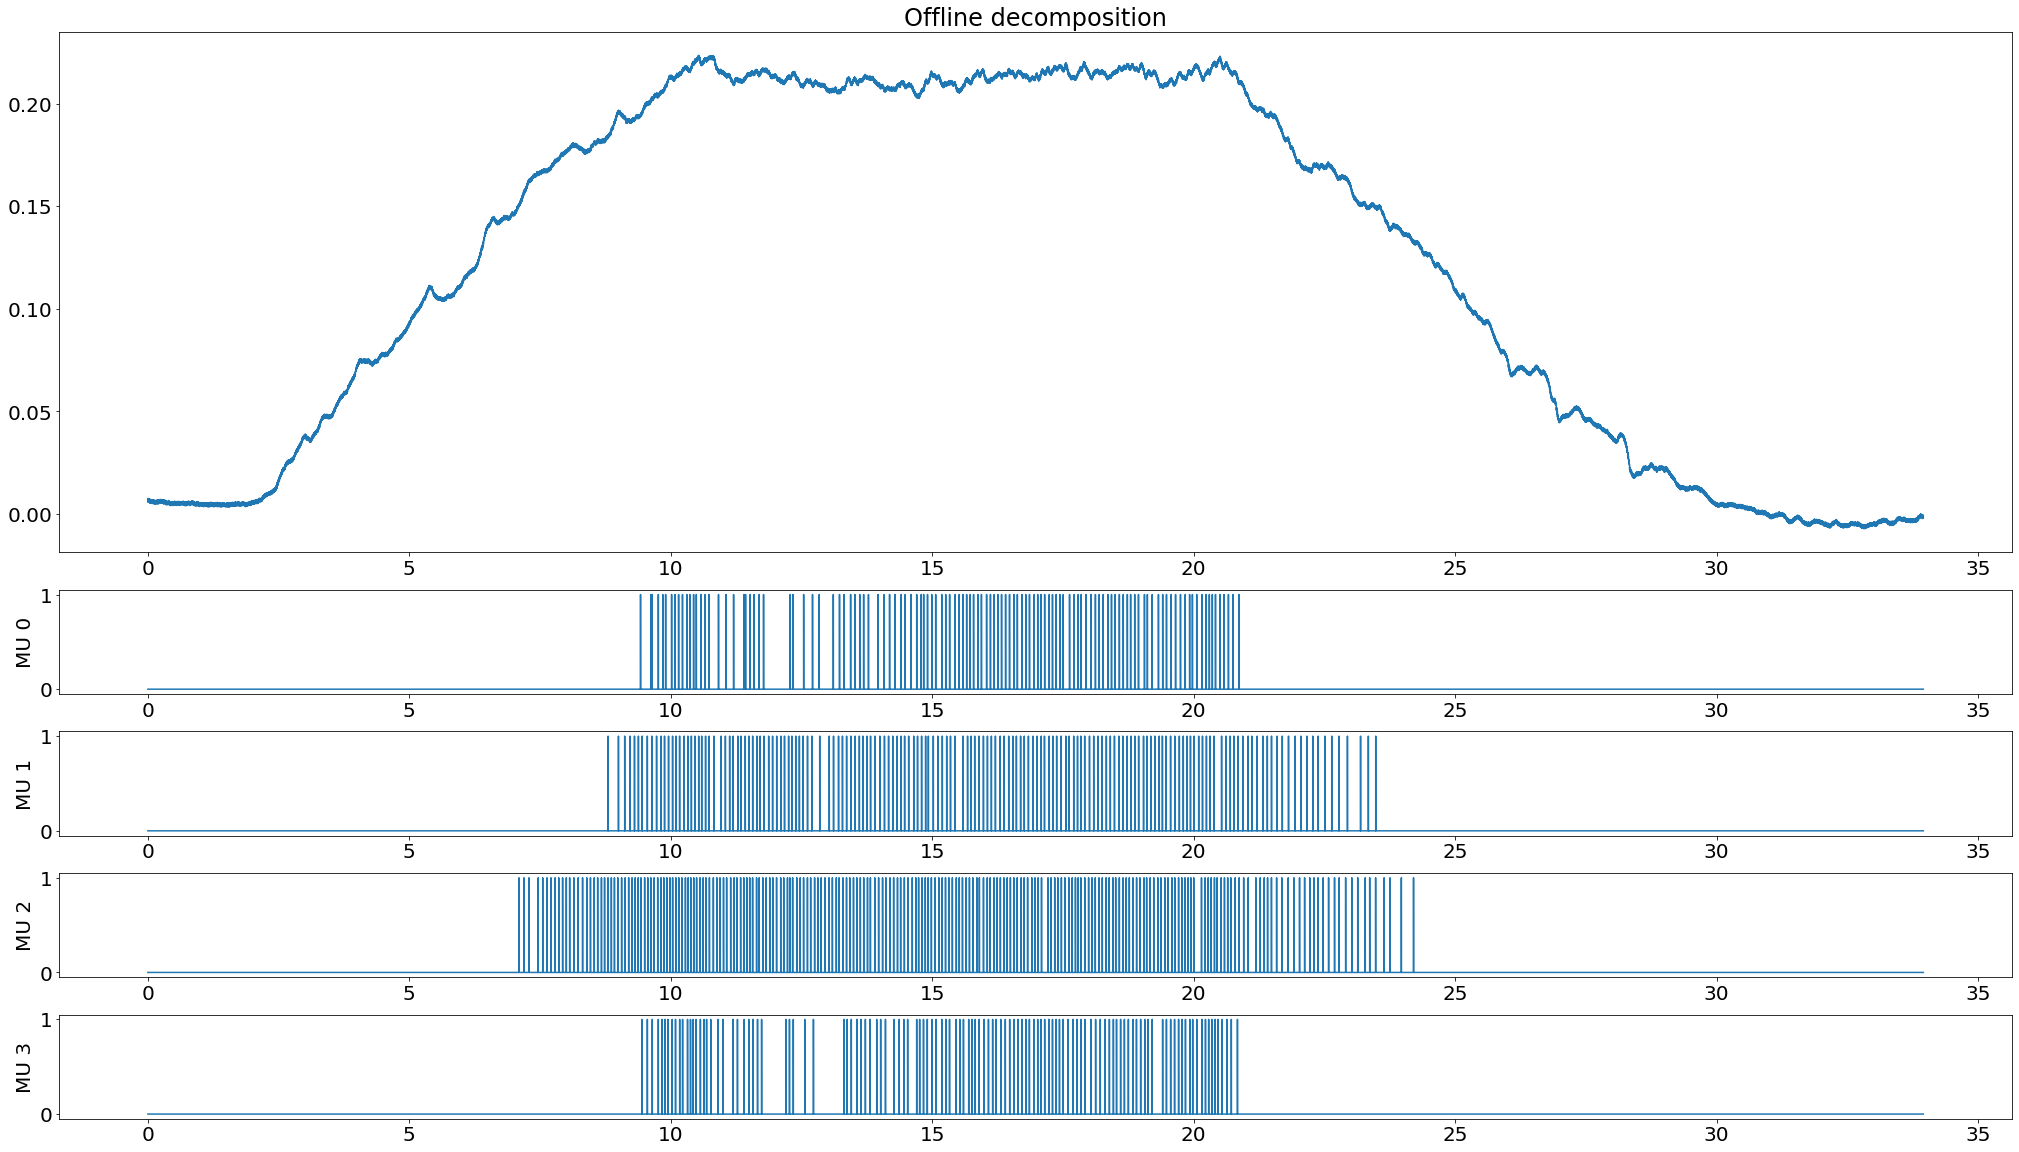

In [10]:
visualize_pt(decomp_ta35_tmod["MUPulses"], 
             data, ref_signal=ref_signal, title="Offline decomposition")

## ii. Separation matrix

In [3]:
decomp = decomp_ta35_x47_x57_x58
bad_ch = disc_ch_flat

# Realtime separation matrix
B = decomp["B"]
B_rt, mean_tm = sep_realtime(data, B, discard=bad_ch)

# Signal and noise centroids
signal_centroids_tm = decomp["peak_centroids"]
noise_centroids_tm = decomp["noise_centroids"]

# s^2 from the offline decomposition
s2_tm = np.square(decomp["s"])

# normalized signal and noise centroids (centroid / max(s^2))
sc_tm = []
nc_tm = []
for i in range(signal_centroids_tm.size):
    sc_tm.append(signal_centroids_tm[i] / signal_centroids_tm.max())
    nc_tm.append(noise_centroids_tm[i] / signal_centroids_tm.max())
sc_tm = np.array(sc_tm)
nc_tm = np.array(nc_tm)

# b. Decomposition module
## i. `kmeans_sil_cp`
### 4.0s, no overlap

In [4]:
kmeans_sil_cp_40 = batch_decomp(data, B_rt, mean_tm, discard = bad_ch, 
                                     use_kmeans=True, thd_noise=0.38, 
                                     classify_mu=True, 
                                     sil_dist=True, 
                                     thd_sil=0.85, 
                                     sc_tm=sc_tm, nc_tm=nc_tm, 
                                     batch_size=batch_size, overlap=0.0)

In [5]:
roa_kmeans_sil_cp_40 = calc_roa(ind_pt1=kmeans_sil_cp_40["MUPulses"], 
                                ind_pt2=decomp["MUPulses"], 
                                data=data, 
                                decomp=f"kmeans_sil_cp {batch_size}s")

RoA between offline decomposition and kmeans_sil_cp 4.0s (%):
Motor unit 0: 0.5333333333333333
Motor unit 1: 0.6600660066006601
Motor unit 2: 0.40080160320641284
Motor unit 3: 0.5649717514124294
Motor unit 4: 1.8469656992084433
mean: 0.8012276787522558


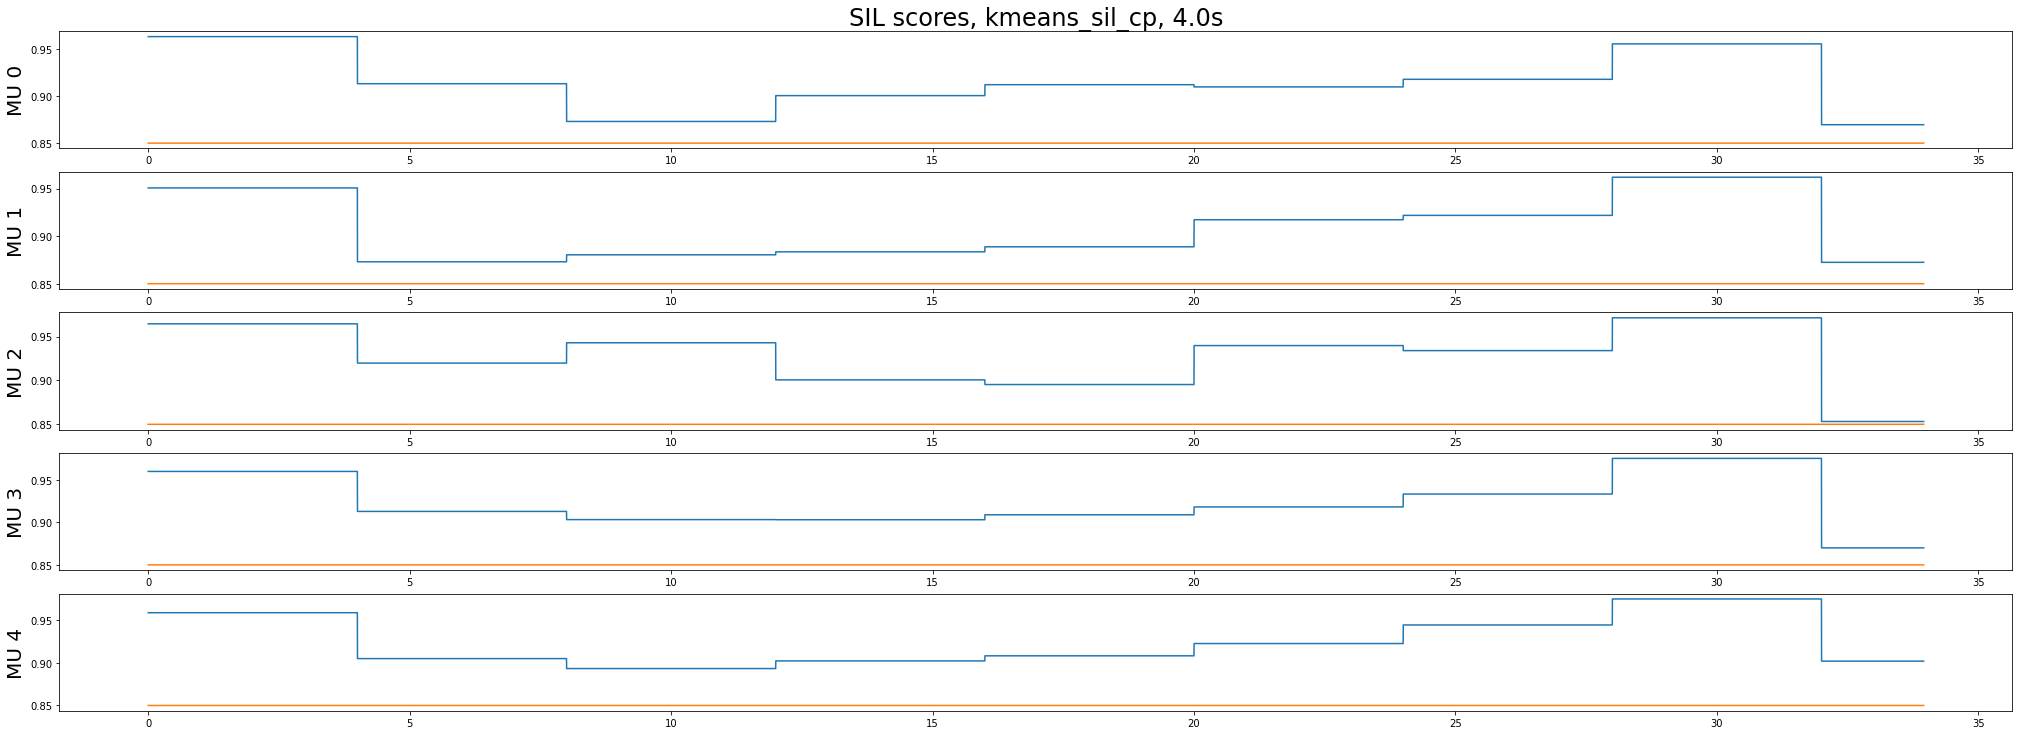

In [6]:
plot_sil(kmeans_sil_cp_40["sil_scores"], thd_sil=0.85,
         title=f"SIL scores, kmeans_sil_cp, {batch_size}s")

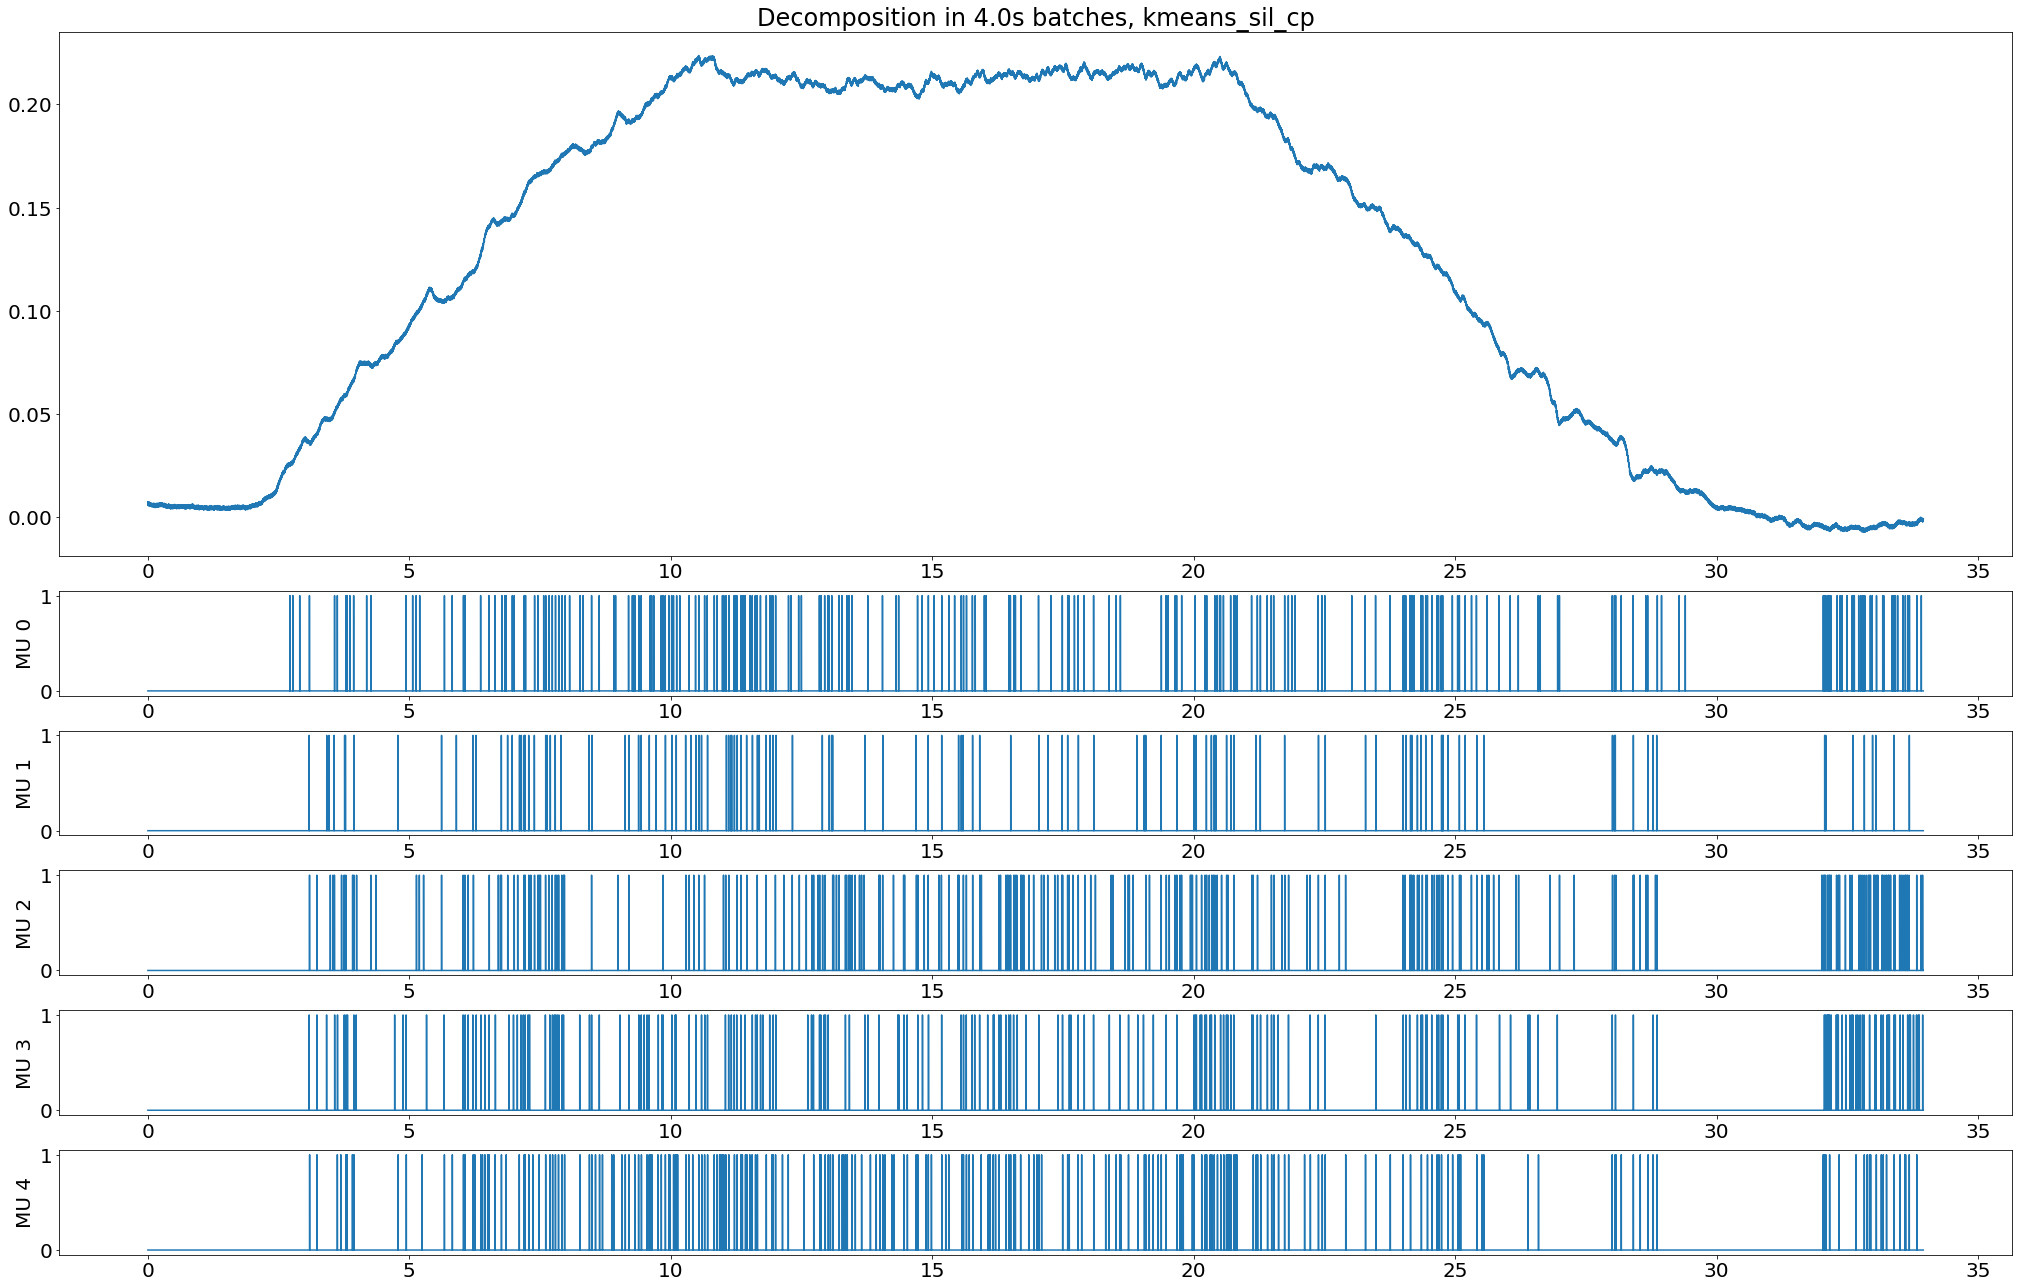

In [7]:
visualize_pt(kmeans_sil_cp_40["MUPulses"], 
             data, ref_signal = ref_signal,
             title=f"Decomposition in {batch_size}s batches, kmeans_sil_cp")

### 4.0s, 1.0s overlap

In [8]:
kmeans_sil_cp_40_ol10 = batch_decomp(data, B_rt, mean_tm, discard = bad_ch, 
                                     use_kmeans=True, thd_noise=0.38, 
                                     classify_mu=True, 
                                     sil_dist=True, 
                                     thd_sil=0.85, 
                                     sc_tm=sc_tm, nc_tm=nc_tm, 
                                     batch_size=batch_size, overlap=ol[0])

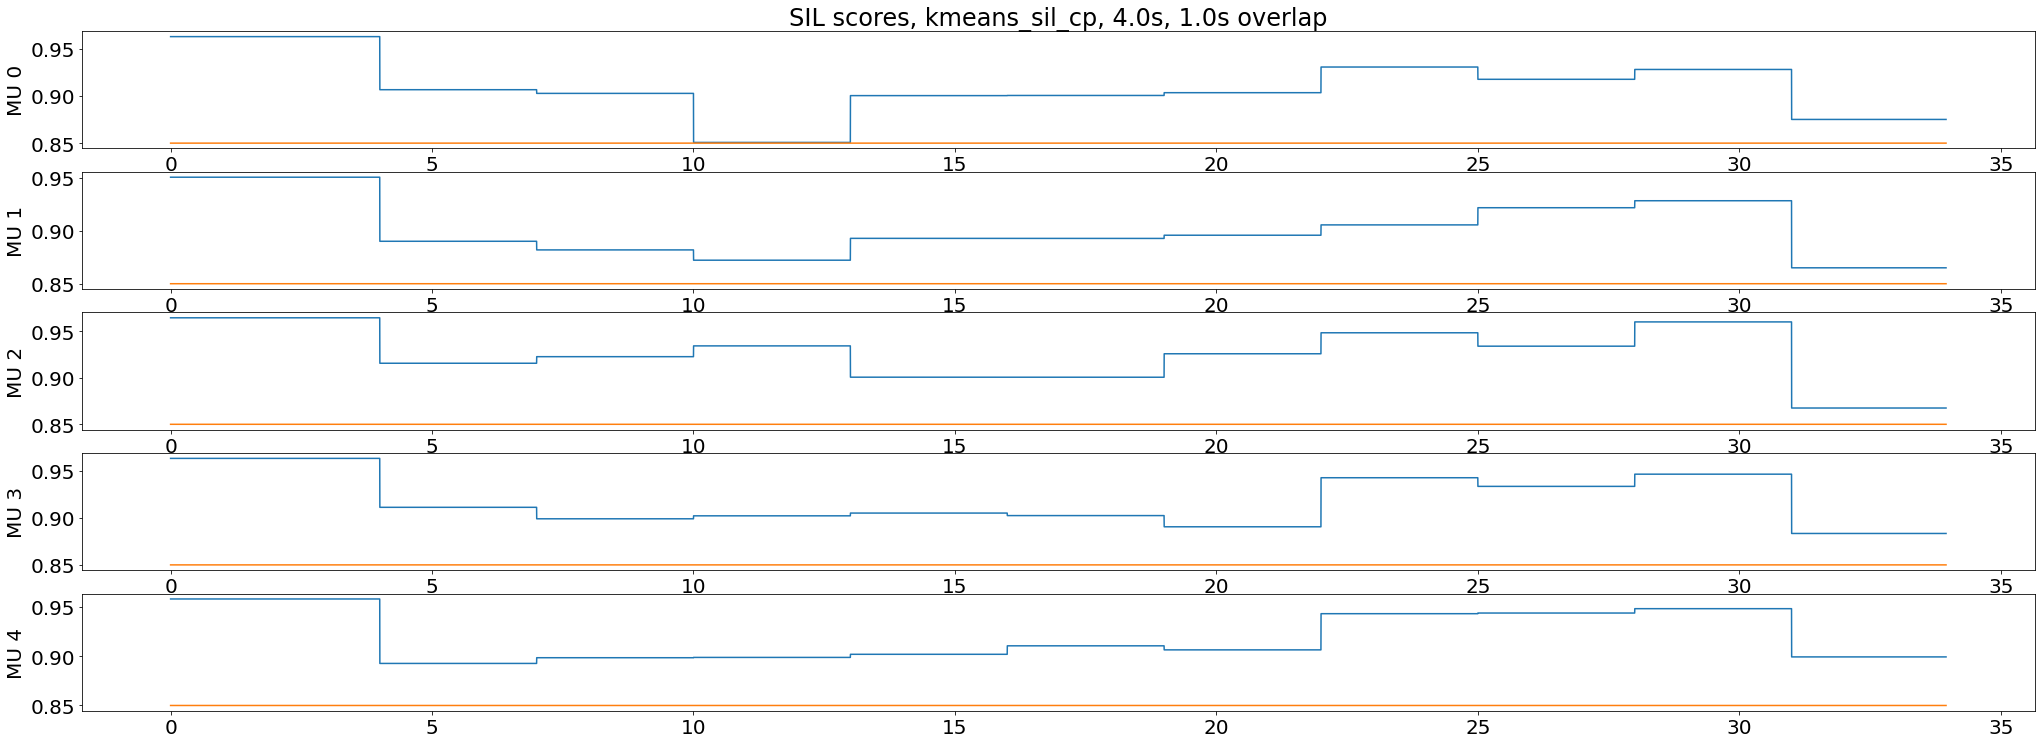

In [9]:
plot_sil(kmeans_sil_cp_40_ol10["sil_scores"], thd_sil=0.85,
         title=f"SIL scores, kmeans_sil_cp, {batch_size}s, {ol[0]}s overlap")

In [10]:
roa_kmeans_sil_cp_40_ol10 = calc_roa(ind_pt1=kmeans_sil_cp_40_ol10["MUPulses"], 
                                    ind_pt2=decomp["MUPulses"], 
                                    data=data, 
                                    decomp=f"kmeans_sil_cp {batch_size}s, overlap:{ol[0]}s")

RoA between offline decomposition and kmeans_sil_cp 4.0s, overlap:1.0s (%):
Motor unit 0: 0.5037783375314862
Motor unit 1: 0.625
Motor unit 2: 0.38910505836575876
Motor unit 3: 0.554016620498615
Motor unit 4: 1.745635910224439
mean: 0.7635071853240598


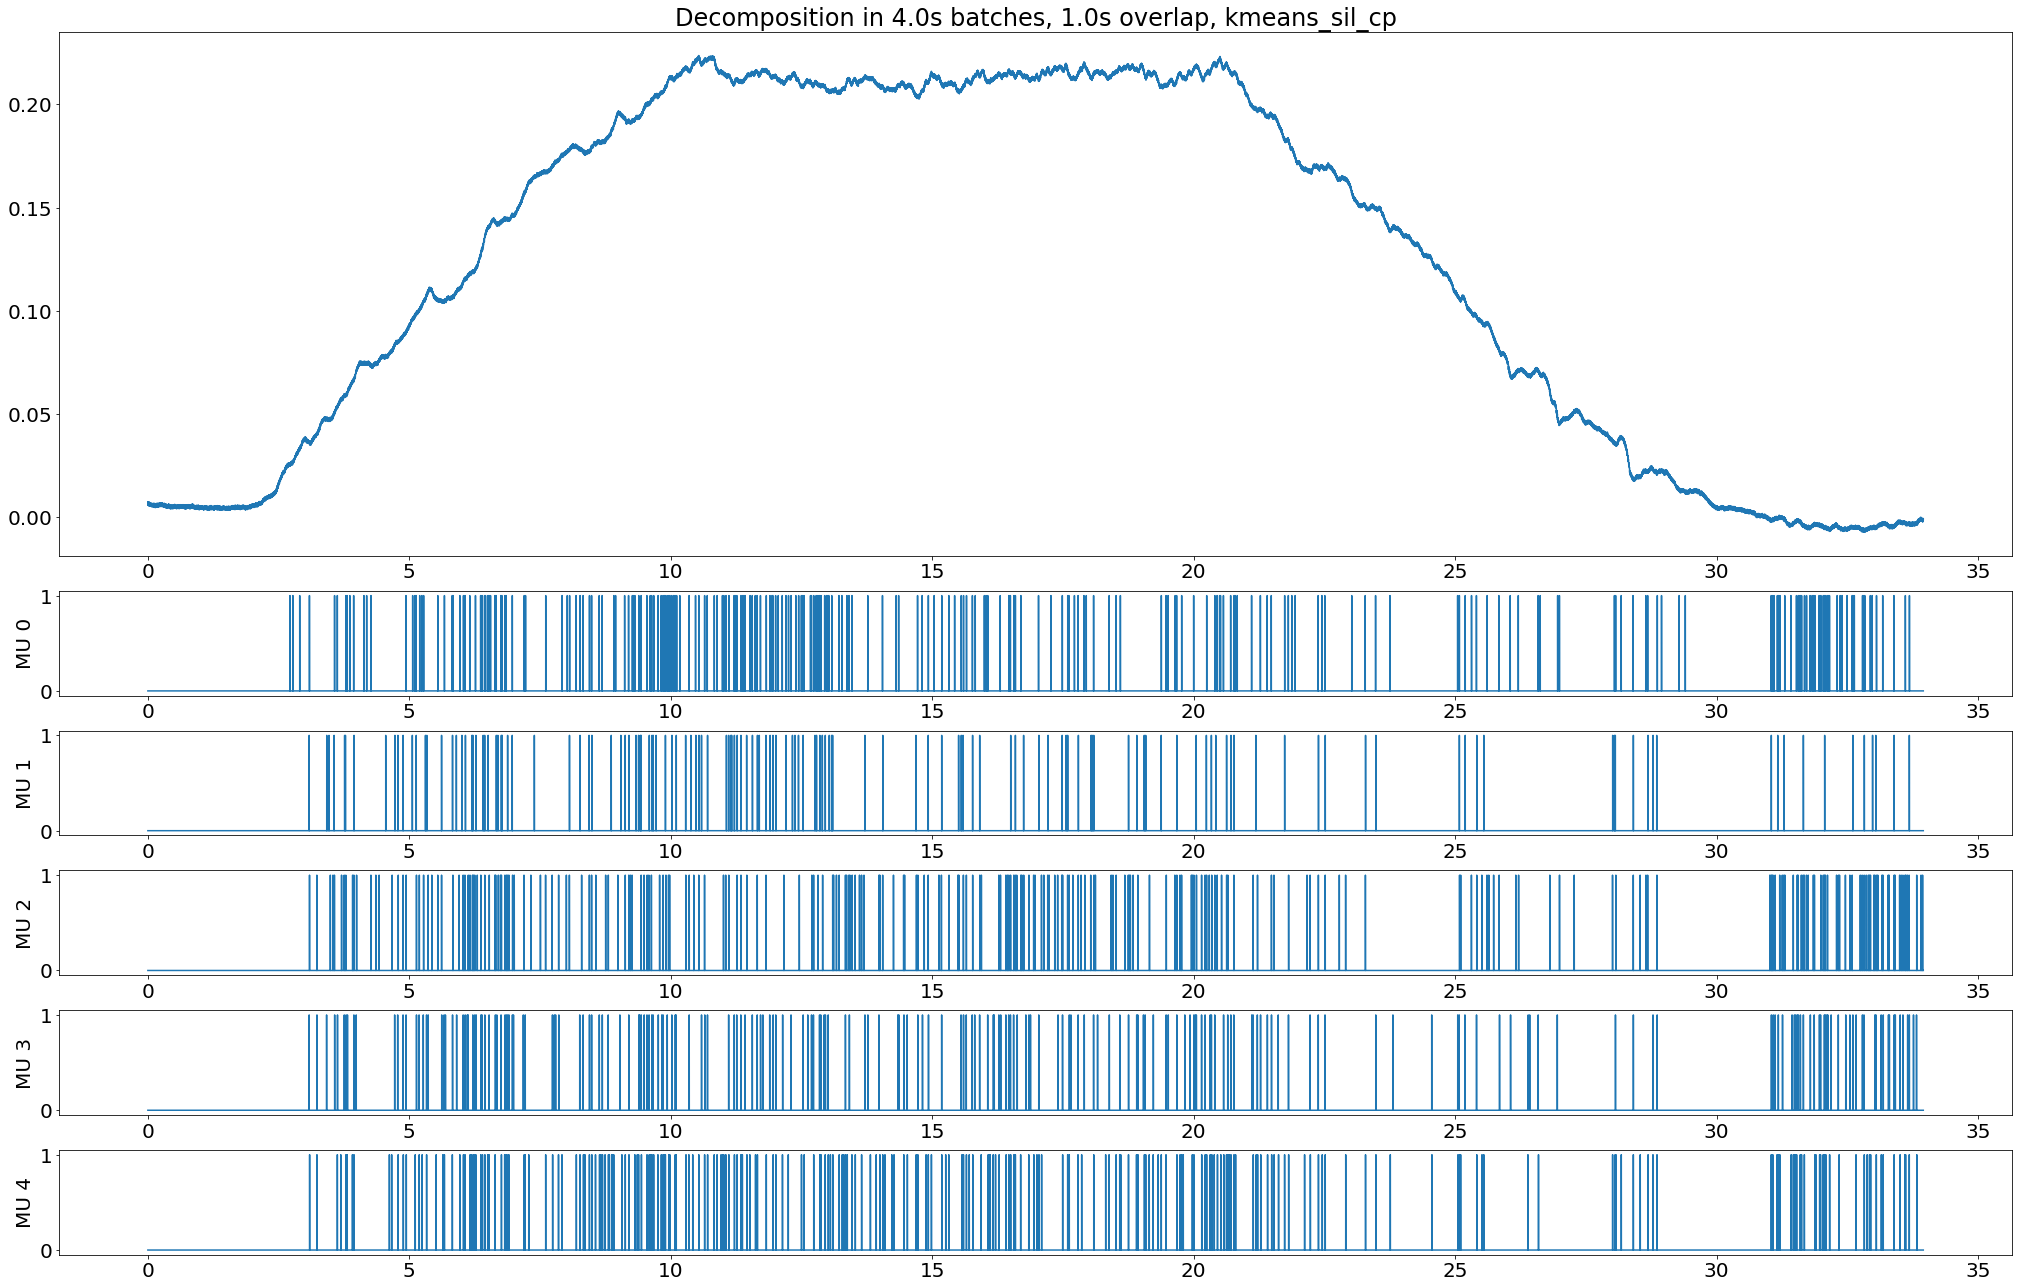

In [11]:
visualize_pt(kmeans_sil_cp_40_ol10["MUPulses"], 
             data, ref_signal=ref_signal,
             title=f"Decomposition in {batch_size}s batches, {ol[0]}s overlap, kmeans_sil_cp")

### 4.0s, 2.0s overlap

In [12]:
kmeans_sil_cp_40_ol20 = batch_decomp(data, B_rt, mean_tm, discard = bad_ch, 
                                     use_kmeans=True, thd_noise=0.38, 
                                     classify_mu=True, 
                                     sil_dist=True, 
                                     thd_sil=0.85, 
                                     sc_tm=sc_tm, nc_tm=nc_tm, 
                                     batch_size=batch_size, overlap=ol[1])

In [13]:
roa_kmeans_sil_cp_40_ol20 = calc_roa(ind_pt1=kmeans_sil_cp_40_ol20["MUPulses"], 
                                    ind_pt2=decomp["MUPulses"], 
                                    data=data, 
                                    decomp=f"kmeans_sil_cp {batch_size}s, overlap:{ol[1]}s")

RoA between offline decomposition and kmeans_sil_cp 4.0s, overlap:2.0s (%):
Motor unit 0: 0.5333333333333333
Motor unit 1: 0.9375
Motor unit 2: 0.40080160320641284
Motor unit 3: 0.5730659025787965
Motor unit 4: 1.8087855297157622
mean: 0.850697273766861


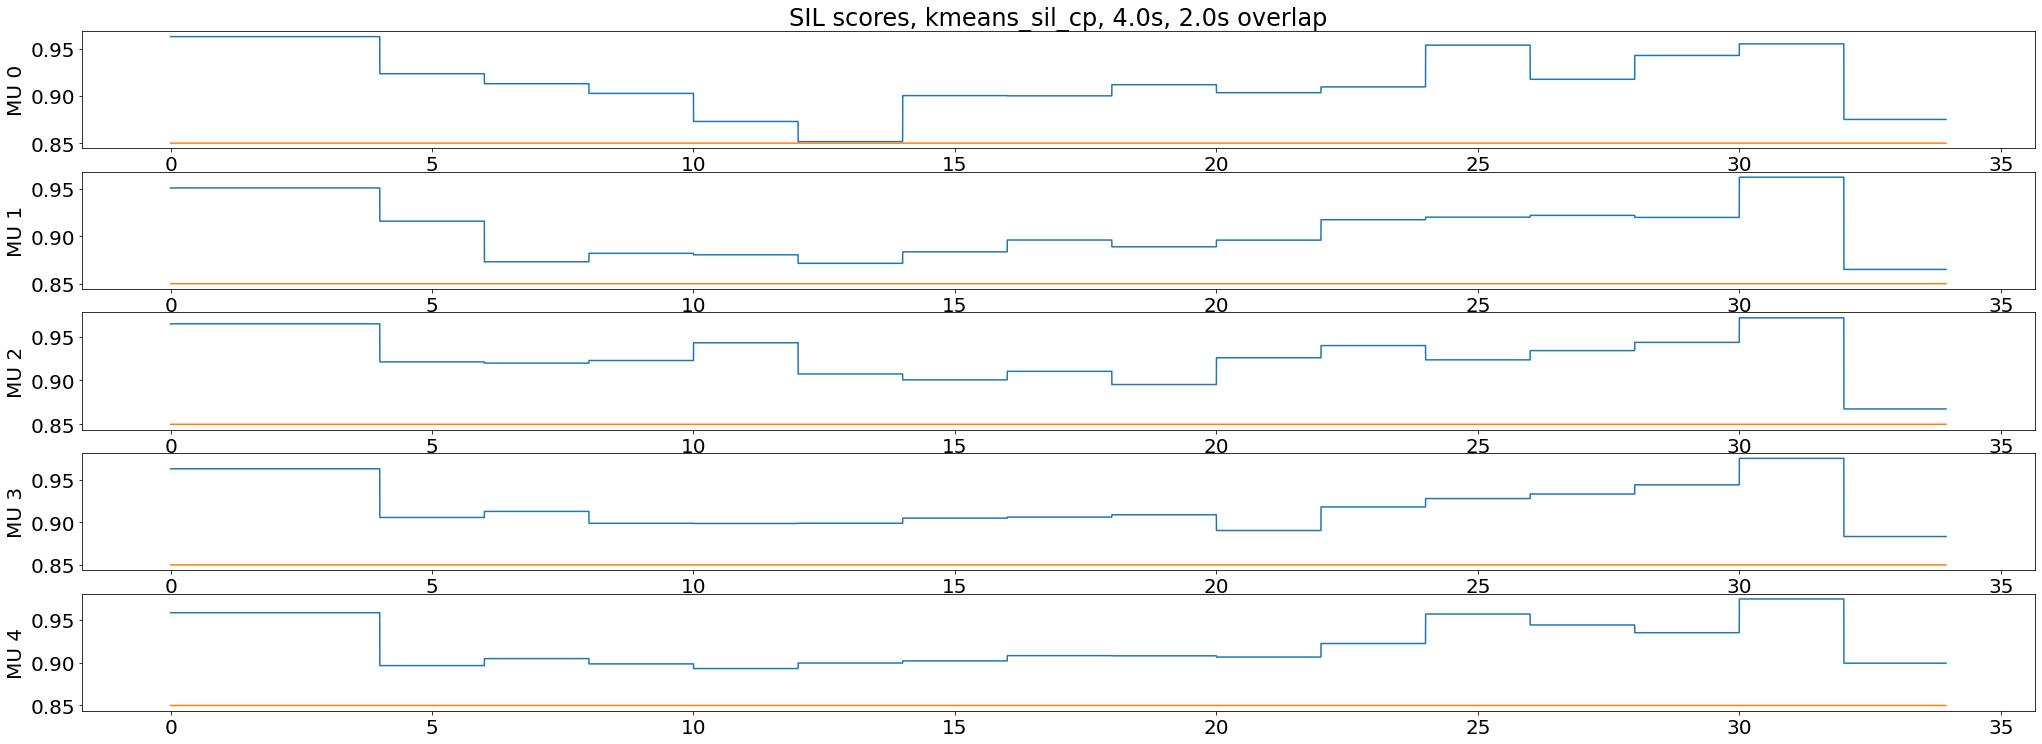

In [14]:
plot_sil(kmeans_sil_cp_40_ol20["sil_scores"], thd_sil=0.85,
         title=f"SIL scores, kmeans_sil_cp, {batch_size}s, {ol[1]}s overlap")

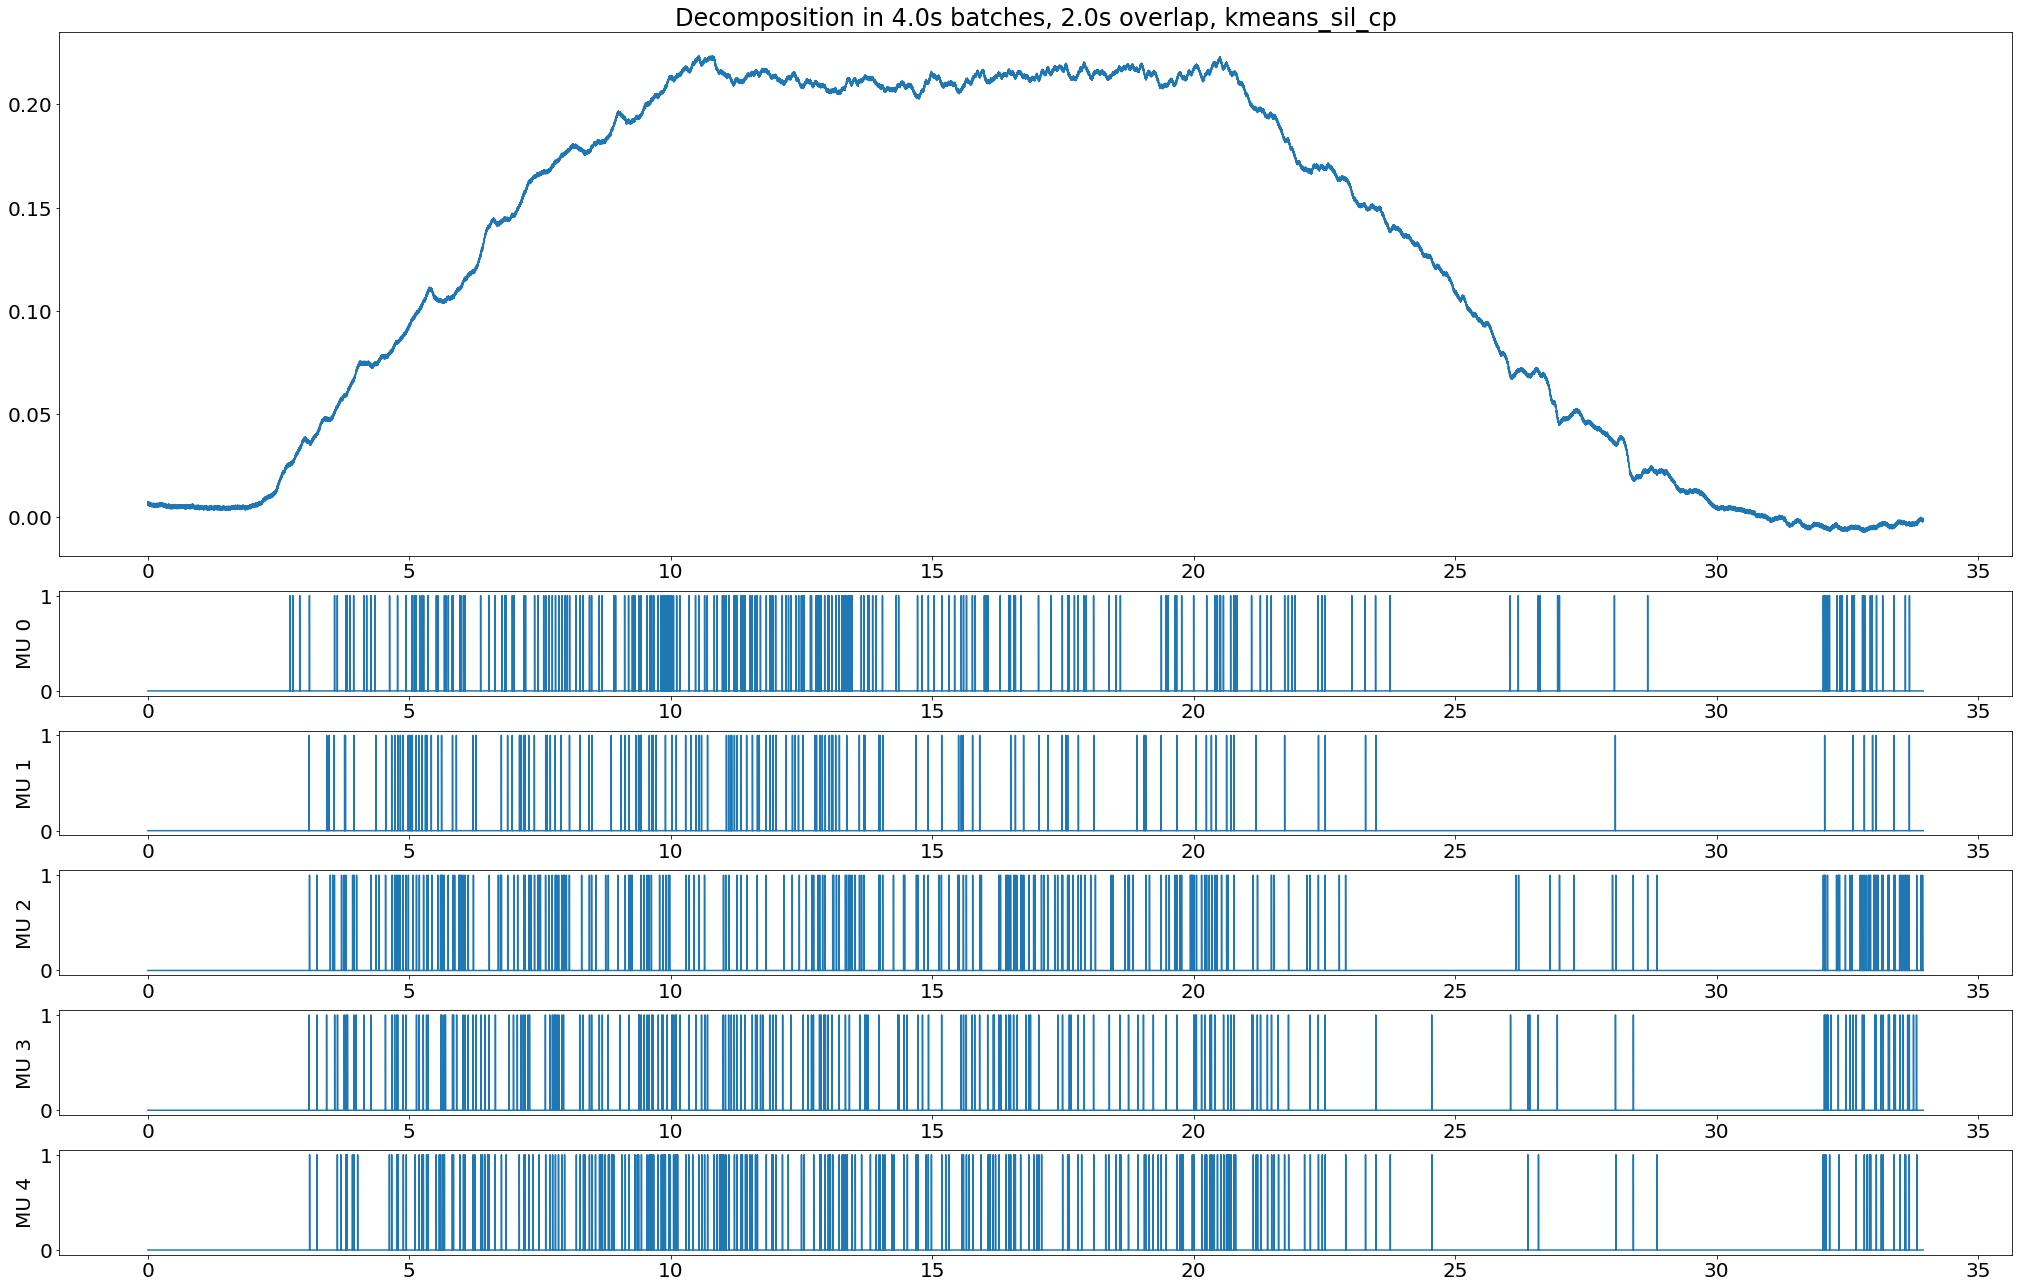

In [15]:
visualize_pt(kmeans_sil_cp_40_ol20["MUPulses"], 
             data, ref_signal=ref_signal,
             title=f"Decomposition in {batch_size}s batches, {ol[1]}s overlap, kmeans_sil_cp")

### 4.0s, 3.0s overlap

In [16]:
kmeans_sil_cp_40_ol30 = batch_decomp(data, B_rt, mean_tm, discard = bad_ch, 
                                     use_kmeans=True, thd_noise=0.38, 
                                     classify_mu=True, 
                                     sil_dist=True, 
                                     thd_sil=0.85, 
                                     sc_tm=sc_tm, nc_tm=nc_tm, 
                                     batch_size=batch_size, overlap=ol[2])

In [17]:
roa_kmeans_sil_cp_40_ol30 = calc_roa(ind_pt1=kmeans_sil_cp_40_ol30["MUPulses"], 
                                    ind_pt2=decomp["MUPulses"], 
                                    data=data, 
                                    decomp=f"kmeans_sil_cp {batch_size}s, overlap:{ol[2]}s")

RoA between offline decomposition and kmeans_sil_cp 4.0s, overlap:3.0s (%):
Motor unit 0: 0.5434782608695652
Motor unit 1: 1.1904761904761905
Motor unit 2: 0.40160642570281124
Motor unit 3: 0.5633802816901409
Motor unit 4: 2.035623409669211
mean: 0.9469129136815837


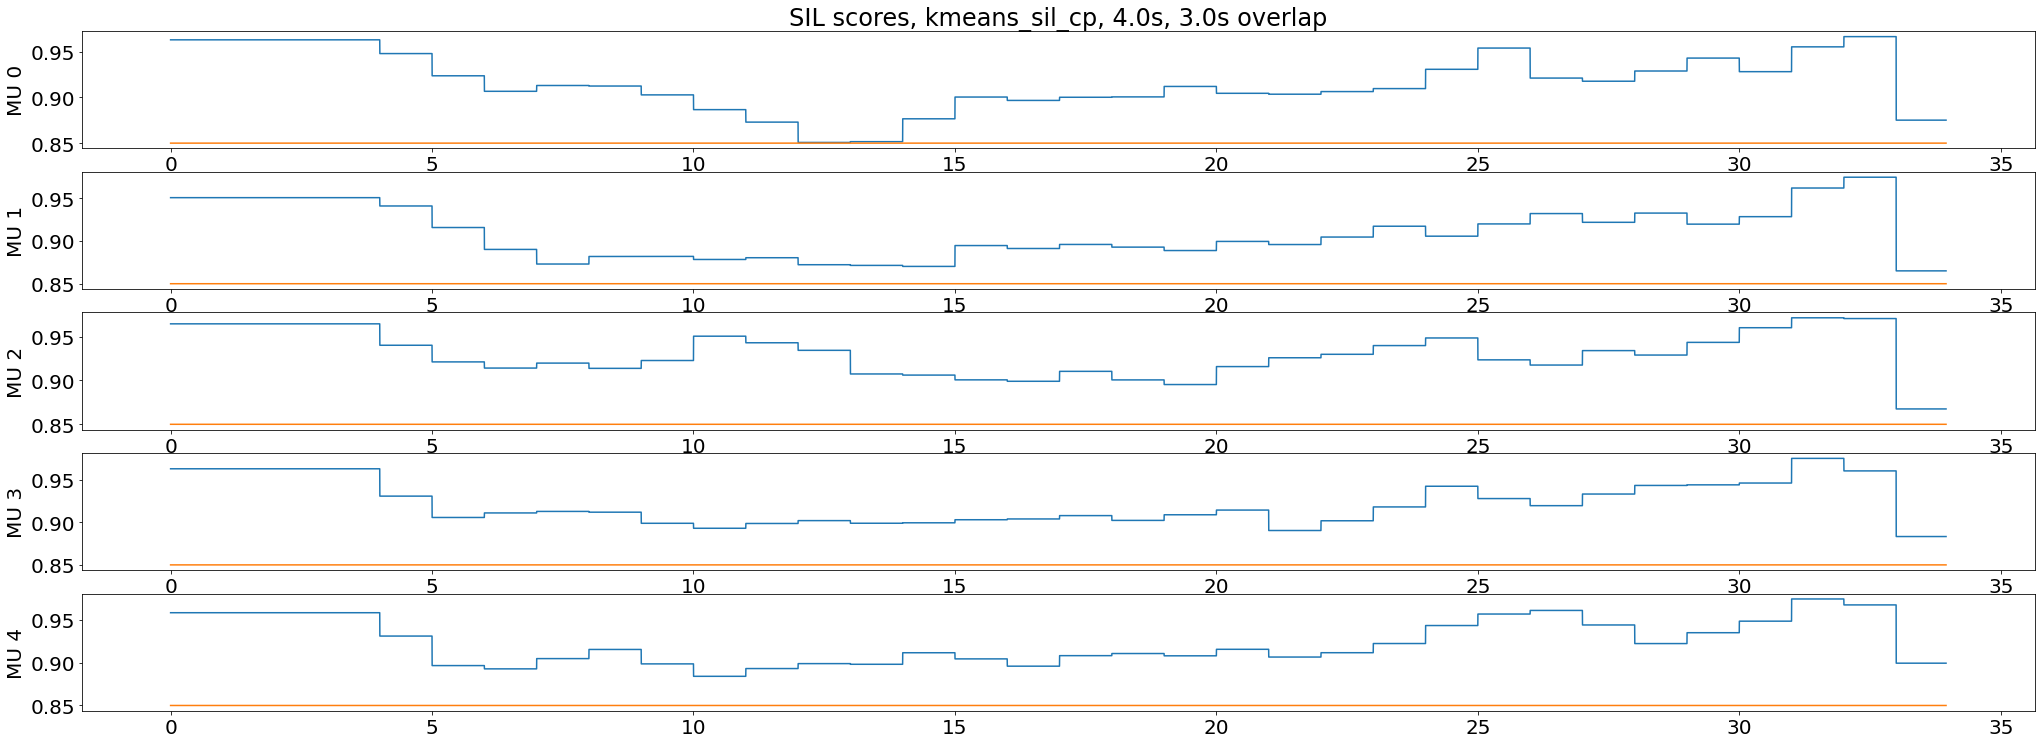

In [18]:
plot_sil(kmeans_sil_cp_40_ol30["sil_scores"], thd_sil=0.85,
         title=f"SIL scores, kmeans_sil_cp, {batch_size}s, {ol[2]}s overlap")

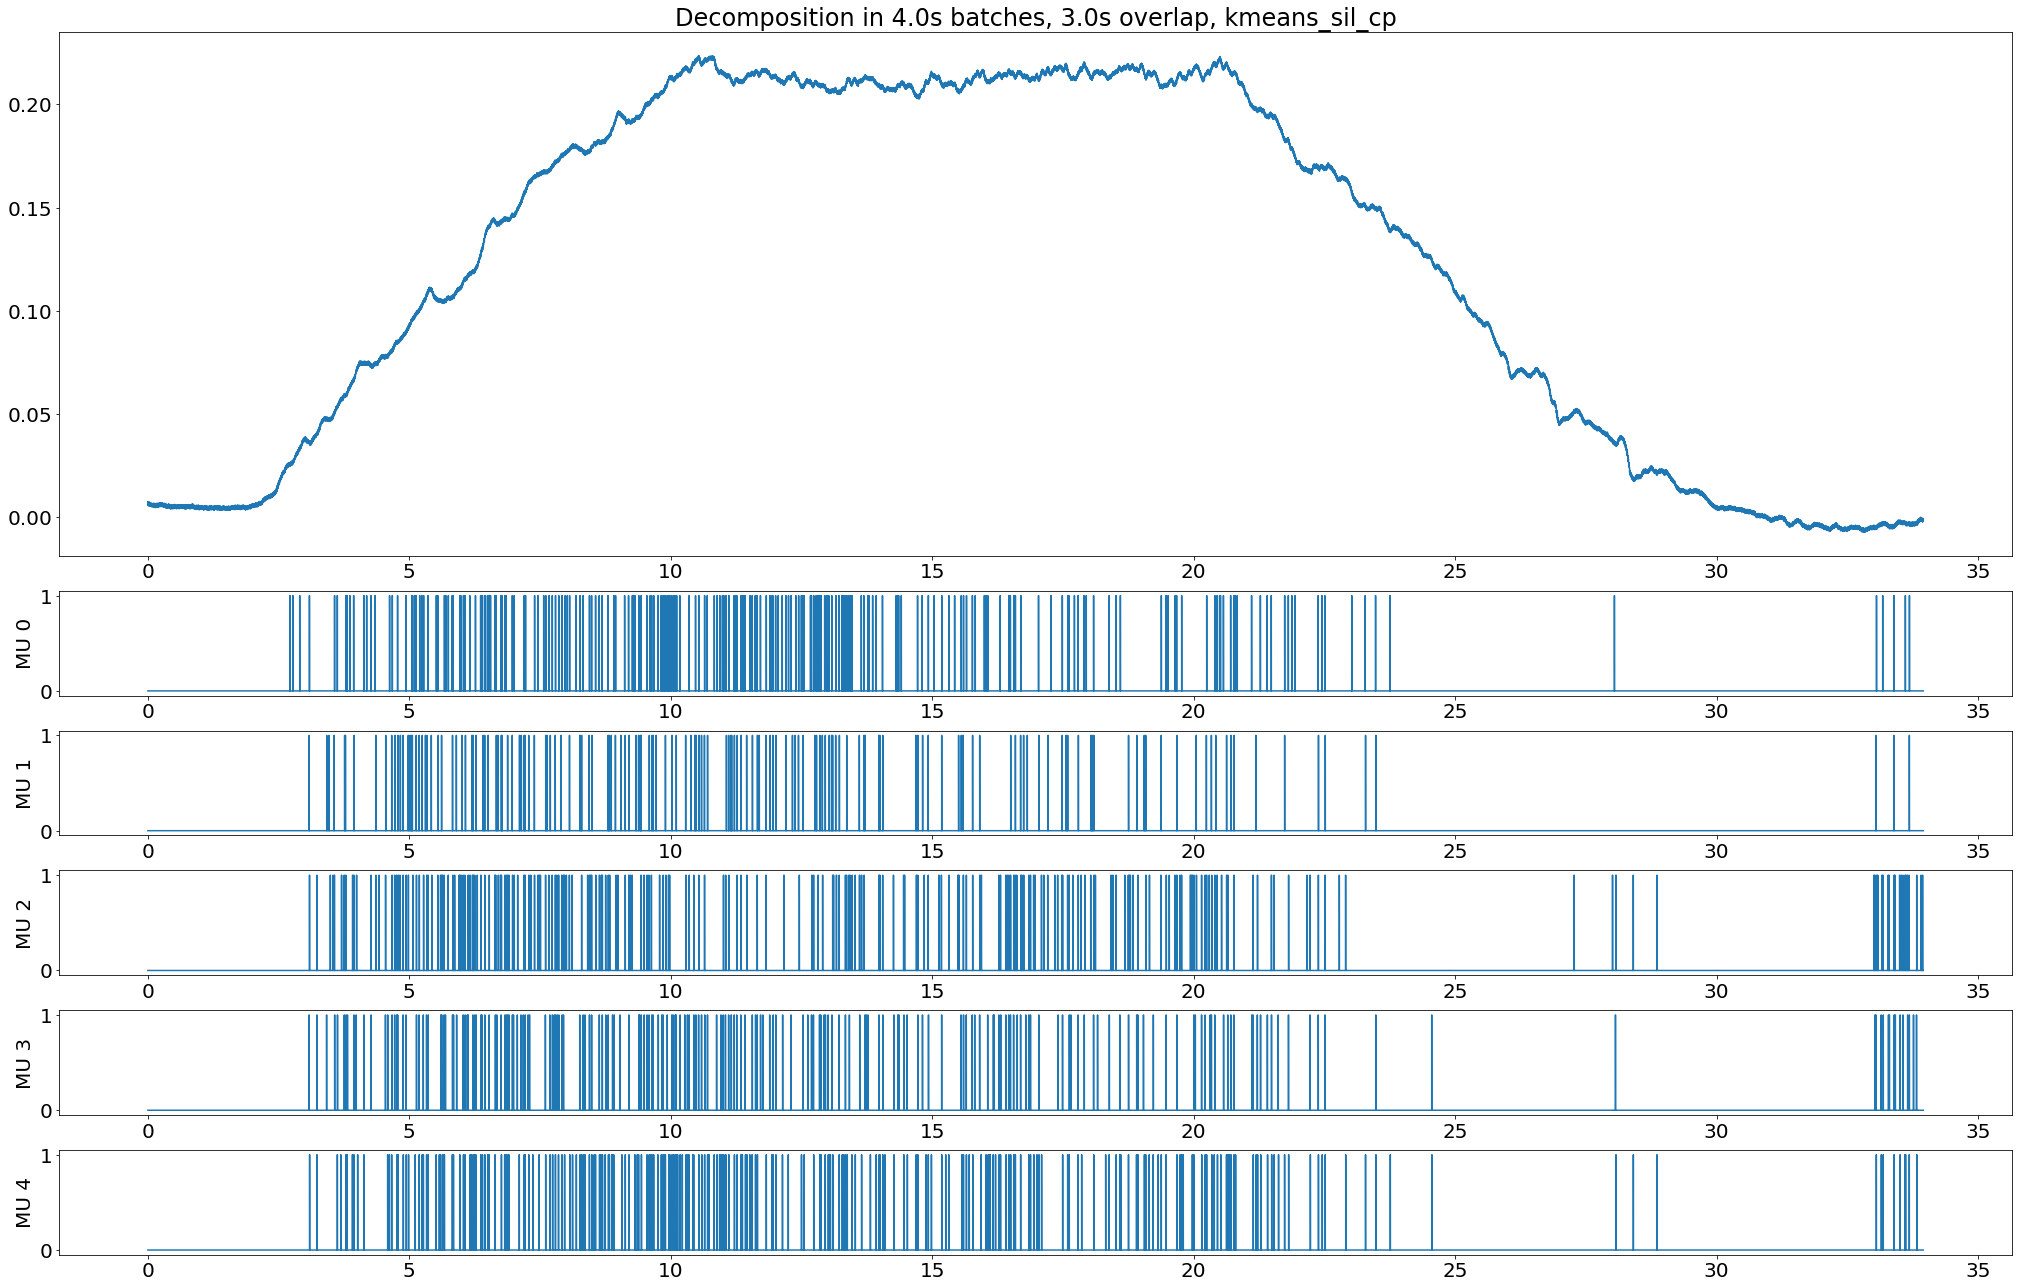

In [19]:
visualize_pt(kmeans_sil_cp_40_ol30["MUPulses"], 
             data, ref_signal=ref_signal,
             title=f"Decomposition in {batch_size}s batches, {ol[2]}s overlap, kmeans_sil_cp")

## ii. `kmeans_cp_window`
### 4.0s, no overlap

In [20]:
kmeans_sil_cp_window_40 = batch_decomp_window(data, B_rt, mean_tm, discard = bad_ch, 
                                     use_kmeans=True, thd_noise=0.38, 
                                     classify_mu=False, 
                                     sil_dist=True, 
                                     thd_sil=0.85, 
                                     thd_pps=5,
                                     sc_tm=sc_tm, nc_tm=nc_tm, 
                                     batch_size=batch_size, overlap=0.0)

In [21]:
roa_kmeans_sil_cp_window_40 = calc_roa(ind_pt1=kmeans_sil_cp_window_40["MUPulses"], 
                                ind_pt2=decomp["MUPulses"], 
                                data=data, 
                                decomp=f"kmeans_cp_window {batch_size}s")

RoA between offline decomposition and kmeans_cp_window 4.0s (%):
Motor unit 0: 0.625
Motor unit 1: 0.0
Motor unit 2: 0.23980815347721823
Motor unit 3: 0.6578947368421053
Motor unit 4: 2.1604938271604937
mean: 0.7366393434959635


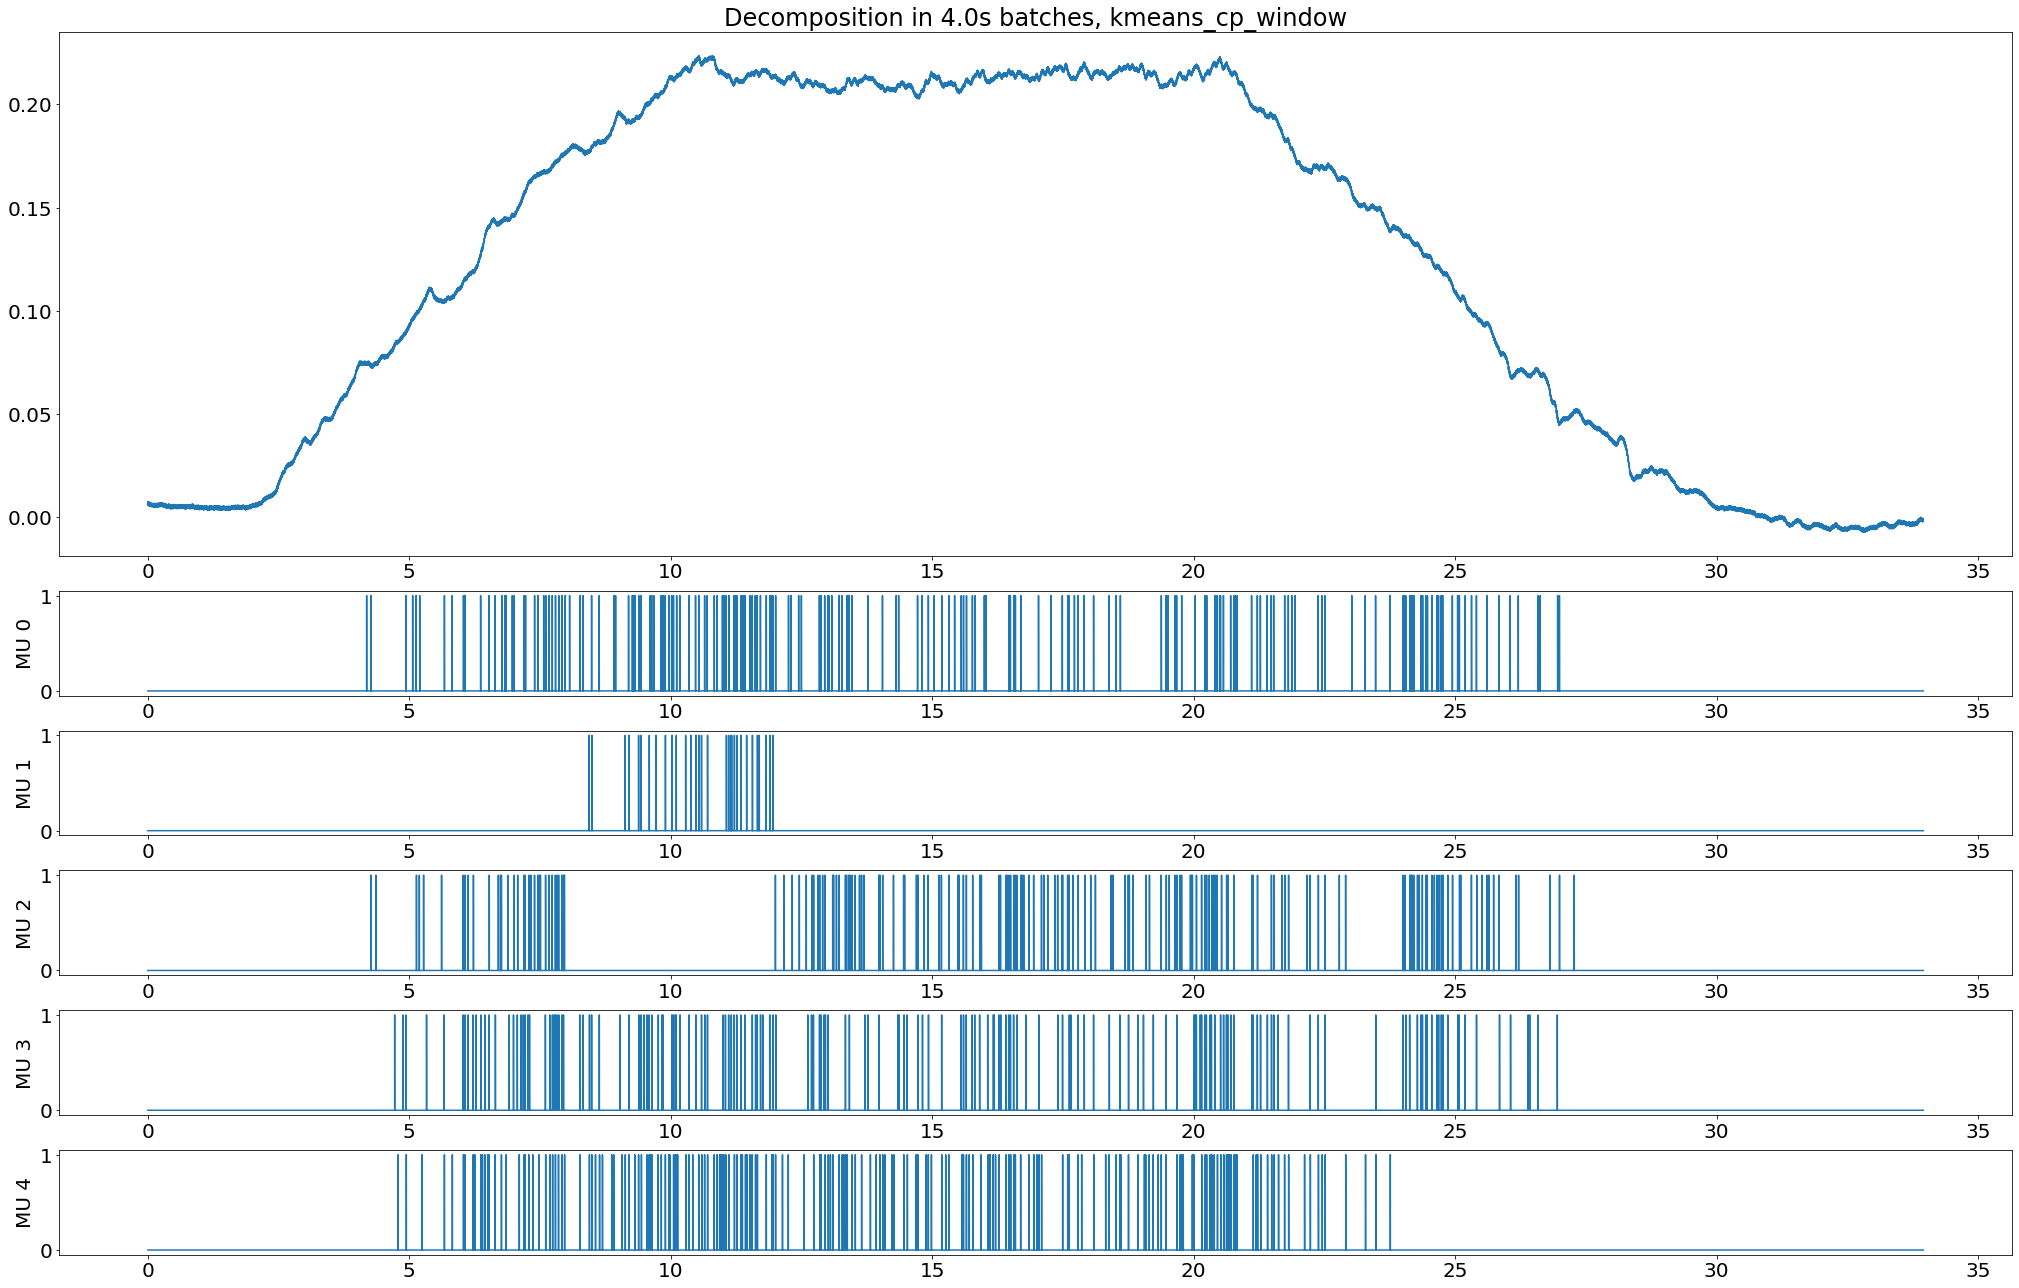

In [22]:
visualize_pt(kmeans_sil_cp_window_40["MUPulses"], 
             data, ref_signal=ref_signal,
             title=f"Decomposition in {batch_size}s batches, kmeans_cp_window")

### 4.0s, 1.0s overlap

In [23]:
kmeans_sil_cp_window_40_ol10 = batch_decomp_window(data, B_rt, mean_tm, discard = bad_ch, 
                                     use_kmeans=True, thd_noise=0.38, 
                                     classify_mu=False, 
                                     sil_dist=True, 
                                     thd_sil=0.85, 
                                     thd_pps=5,
                                     sc_tm=sc_tm, nc_tm=nc_tm, 
                                     batch_size=batch_size, overlap=ol[0])

In [24]:
roa_kmeans_sil_cp_window_40_ol10 = calc_roa(ind_pt1=kmeans_sil_cp_window_40_ol10["MUPulses"], 
                                ind_pt2=decomp["MUPulses"], 
                                data=data, 
                                decomp=f"kmeans_cp_window {batch_size}s, overlap:{ol[0]}s")

RoA between offline decomposition and kmeans_cp_window 4.0s, overlap:1.0s (%):
Motor unit 0: 0.5263157894736842
Motor unit 1: 0.0
Motor unit 2: 0.40160642570281124
Motor unit 3: 0.5865102639296188
Motor unit 4: 1.8617021276595744
mean: 0.6752269213531378


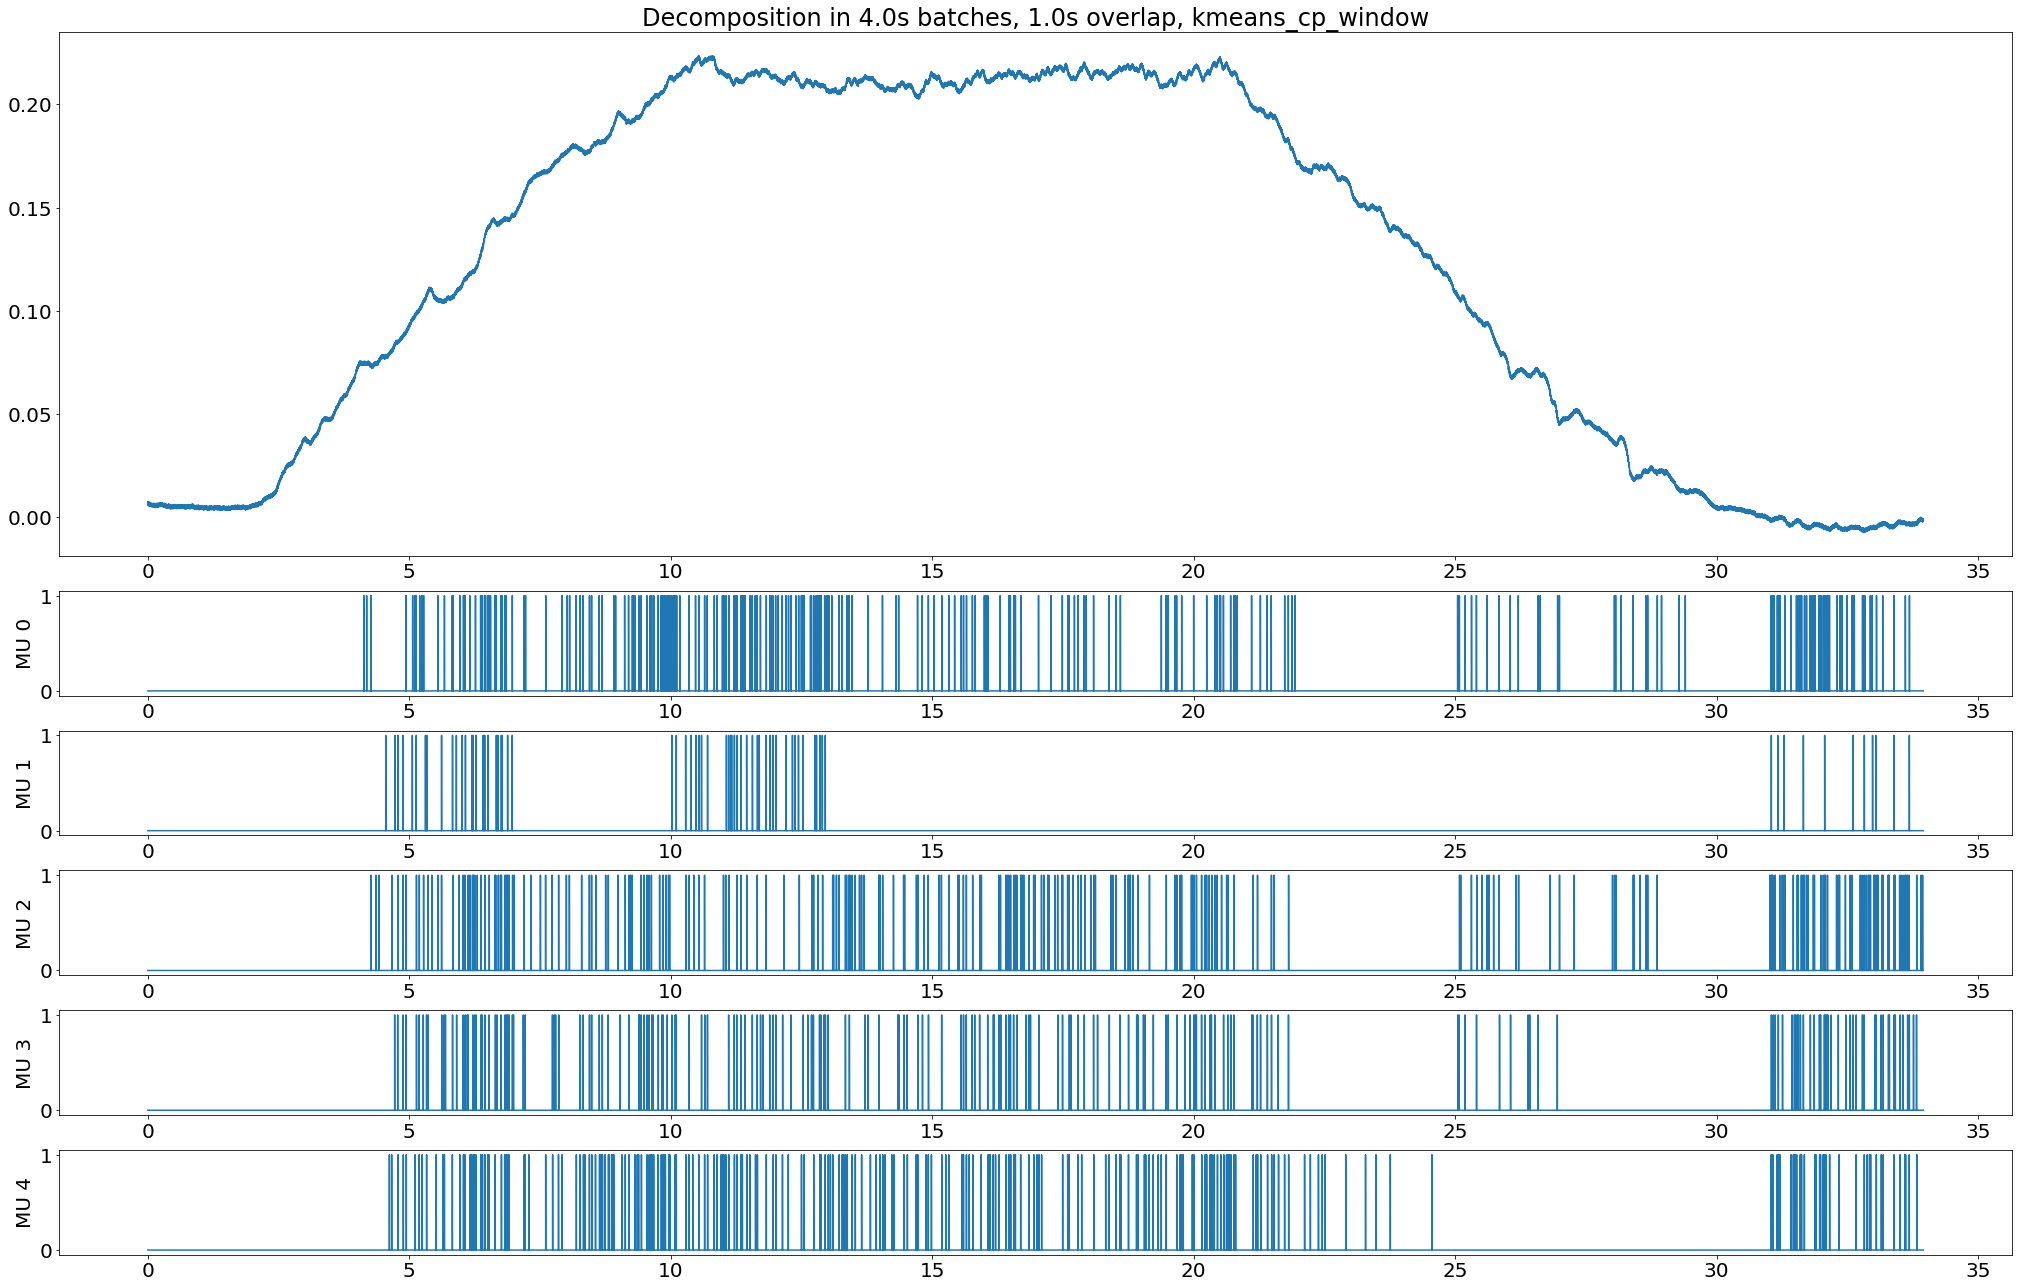

In [25]:
visualize_pt(kmeans_sil_cp_window_40_ol10["MUPulses"], 
             data, ref_signal=ref_signal,
             title=f"Decomposition in {batch_size}s batches, {ol[0]}s overlap, kmeans_cp_window")

### 4.0s, 2.0s overlap

In [26]:
kmeans_sil_cp_window_40_ol20 = batch_decomp_window(data, B_rt, mean_tm, discard = bad_ch, 
                                     use_kmeans=True, thd_noise=0.38, 
                                     classify_mu=False, 
                                     sil_dist=True, 
                                     thd_sil=0.9, 
                                     thd_pps=5,
                                     sc_tm=sc_tm, nc_tm=nc_tm, 
                                     batch_size=batch_size, overlap=ol[1])

In [27]:
roa_kmeans_sil_cp_window_40_ol20 = calc_roa(ind_pt1=kmeans_sil_cp_window_40_ol20["MUPulses"], 
                                ind_pt2=decomp["MUPulses"], 
                                data=data, 
                                decomp=f"kmeans_cp_window {batch_size}s, overlap:{ol[1]}s")

RoA between offline decomposition and kmeans_cp_window 4.0s, overlap:2.0s (%):
Motor unit 0: 0.5509641873278237
Motor unit 1: 0.823045267489712
Motor unit 2: 0.21052631578947367
Motor unit 3: 0.5952380952380952
Motor unit 4: 1.876675603217158
mean: 0.8112898938124525


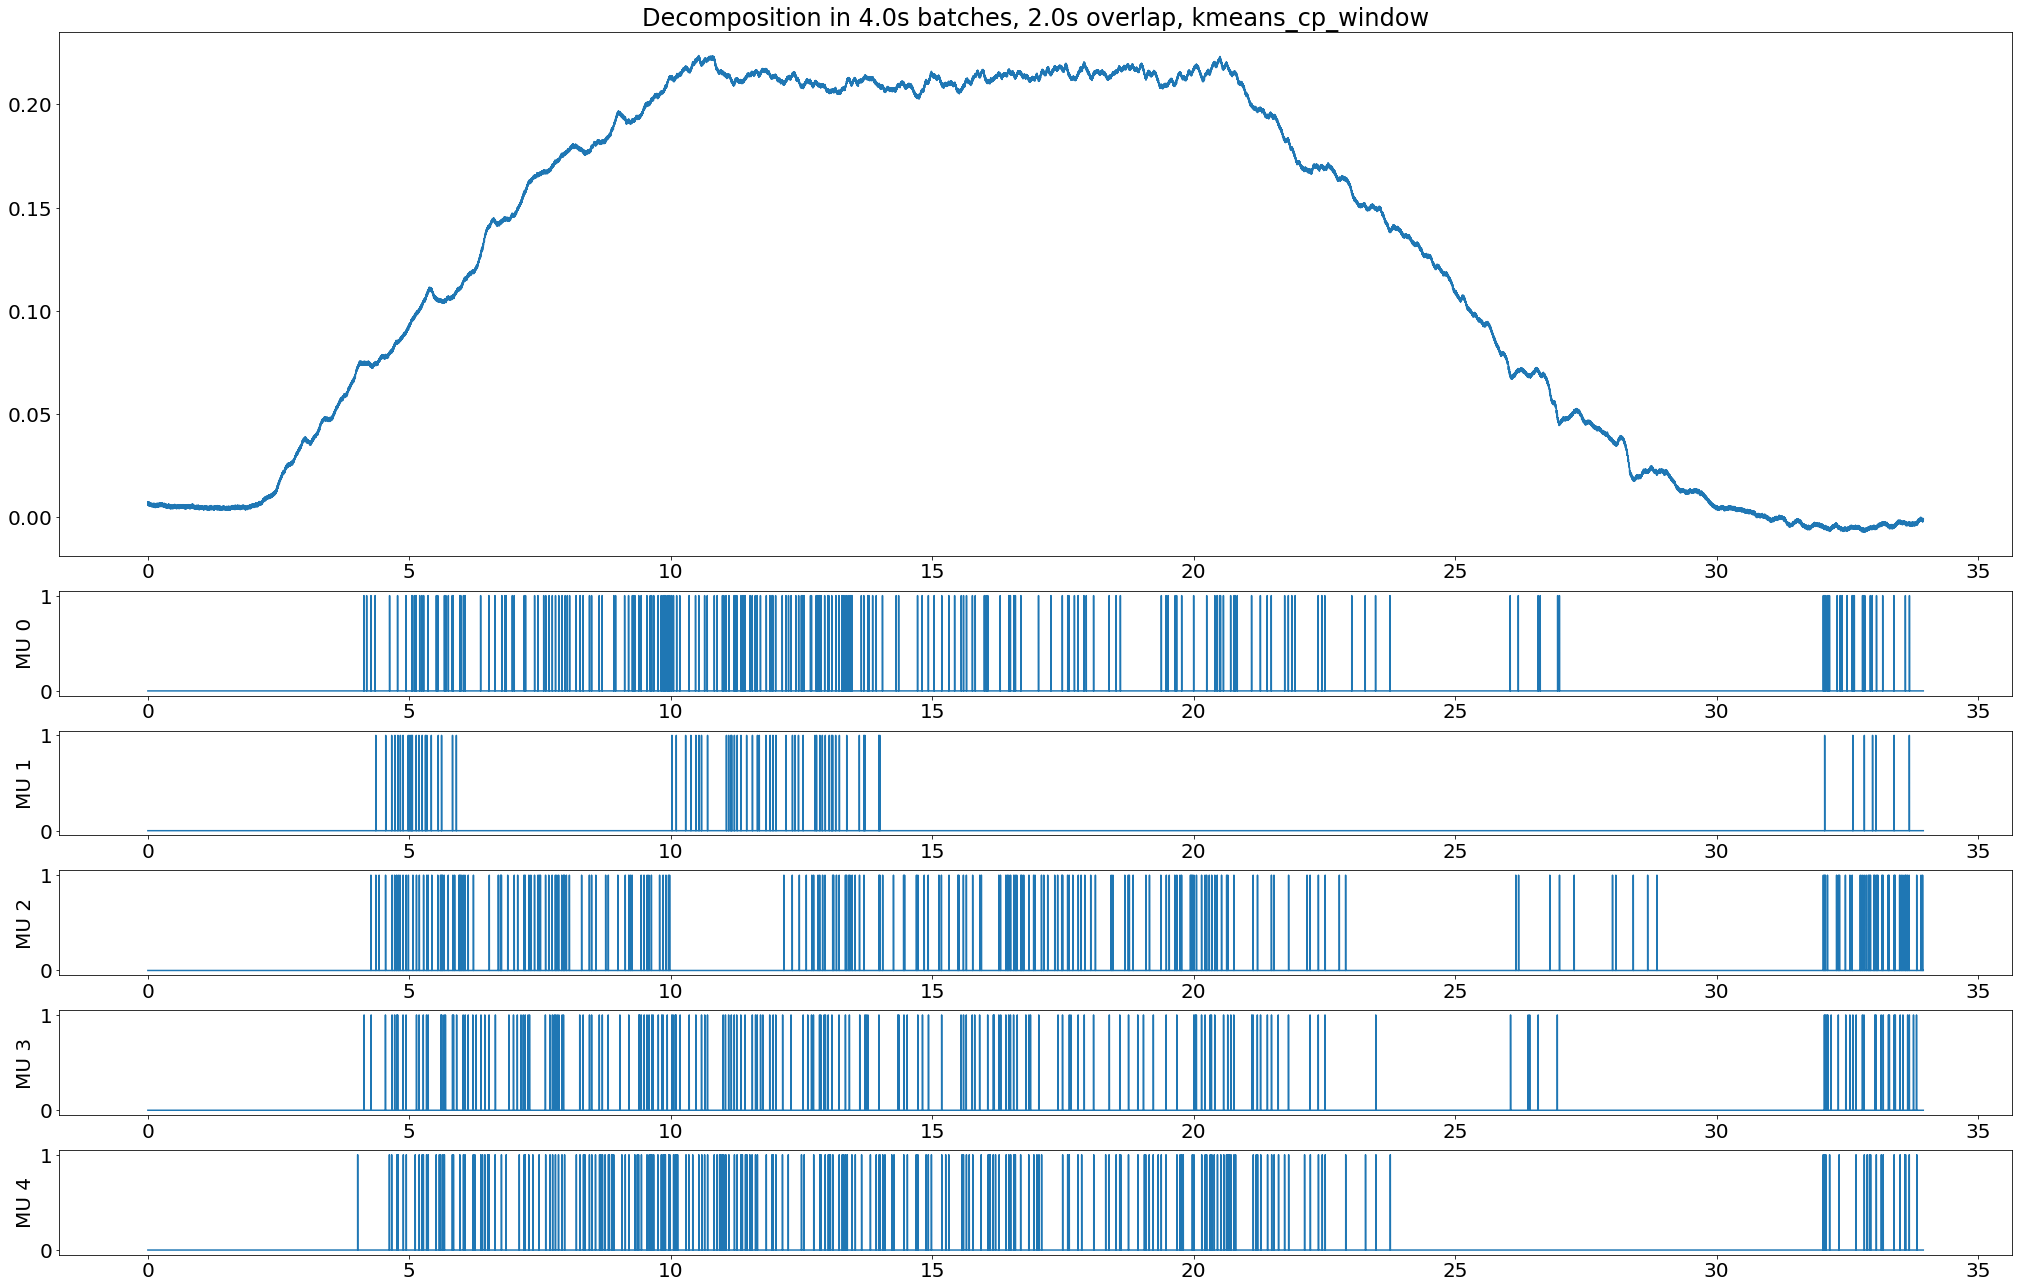

In [28]:
visualize_pt(kmeans_sil_cp_window_40_ol20["MUPulses"], 
             data, ref_signal=ref_signal,
             title=f"Decomposition in {batch_size}s batches, {ol[1]}s overlap, kmeans_cp_window")

### 4.0s, 3.0s overlap

In [29]:
kmeans_sil_cp_40_ol30 = batch_decomp_window(data, B_rt, mean_tm, discard = bad_ch, 
                                     use_kmeans=True, thd_noise=0.38, 
                                     classify_mu=False, 
                                     sil_dist=True, 
                                     thd_sil=0.9,
                                     thd_pps=5, 
                                     sc_tm=sc_tm, nc_tm=nc_tm, 
                                     batch_size=batch_size, overlap=ol[2])

In [30]:
roa_kmeans_sil_cp_40_ol30 = calc_roa(ind_pt1=kmeans_sil_cp_40_ol30["MUPulses"], 
                                    ind_pt2=decomp["MUPulses"], 
                                    data=data, 
                                    decomp=f"kmeans_cp_window {batch_size}s, overlap:{ol[2]}s")

RoA between offline decomposition and kmeans_cp_window 4.0s, overlap:3.0s (%):
Motor unit 0: 0.56657223796034
Motor unit 1: 0.7782101167315175
Motor unit 2: 0.2159827213822894
Motor unit 3: 0.5970149253731343
Motor unit 4: 1.8716577540106951
mean: 0.8058875510915954


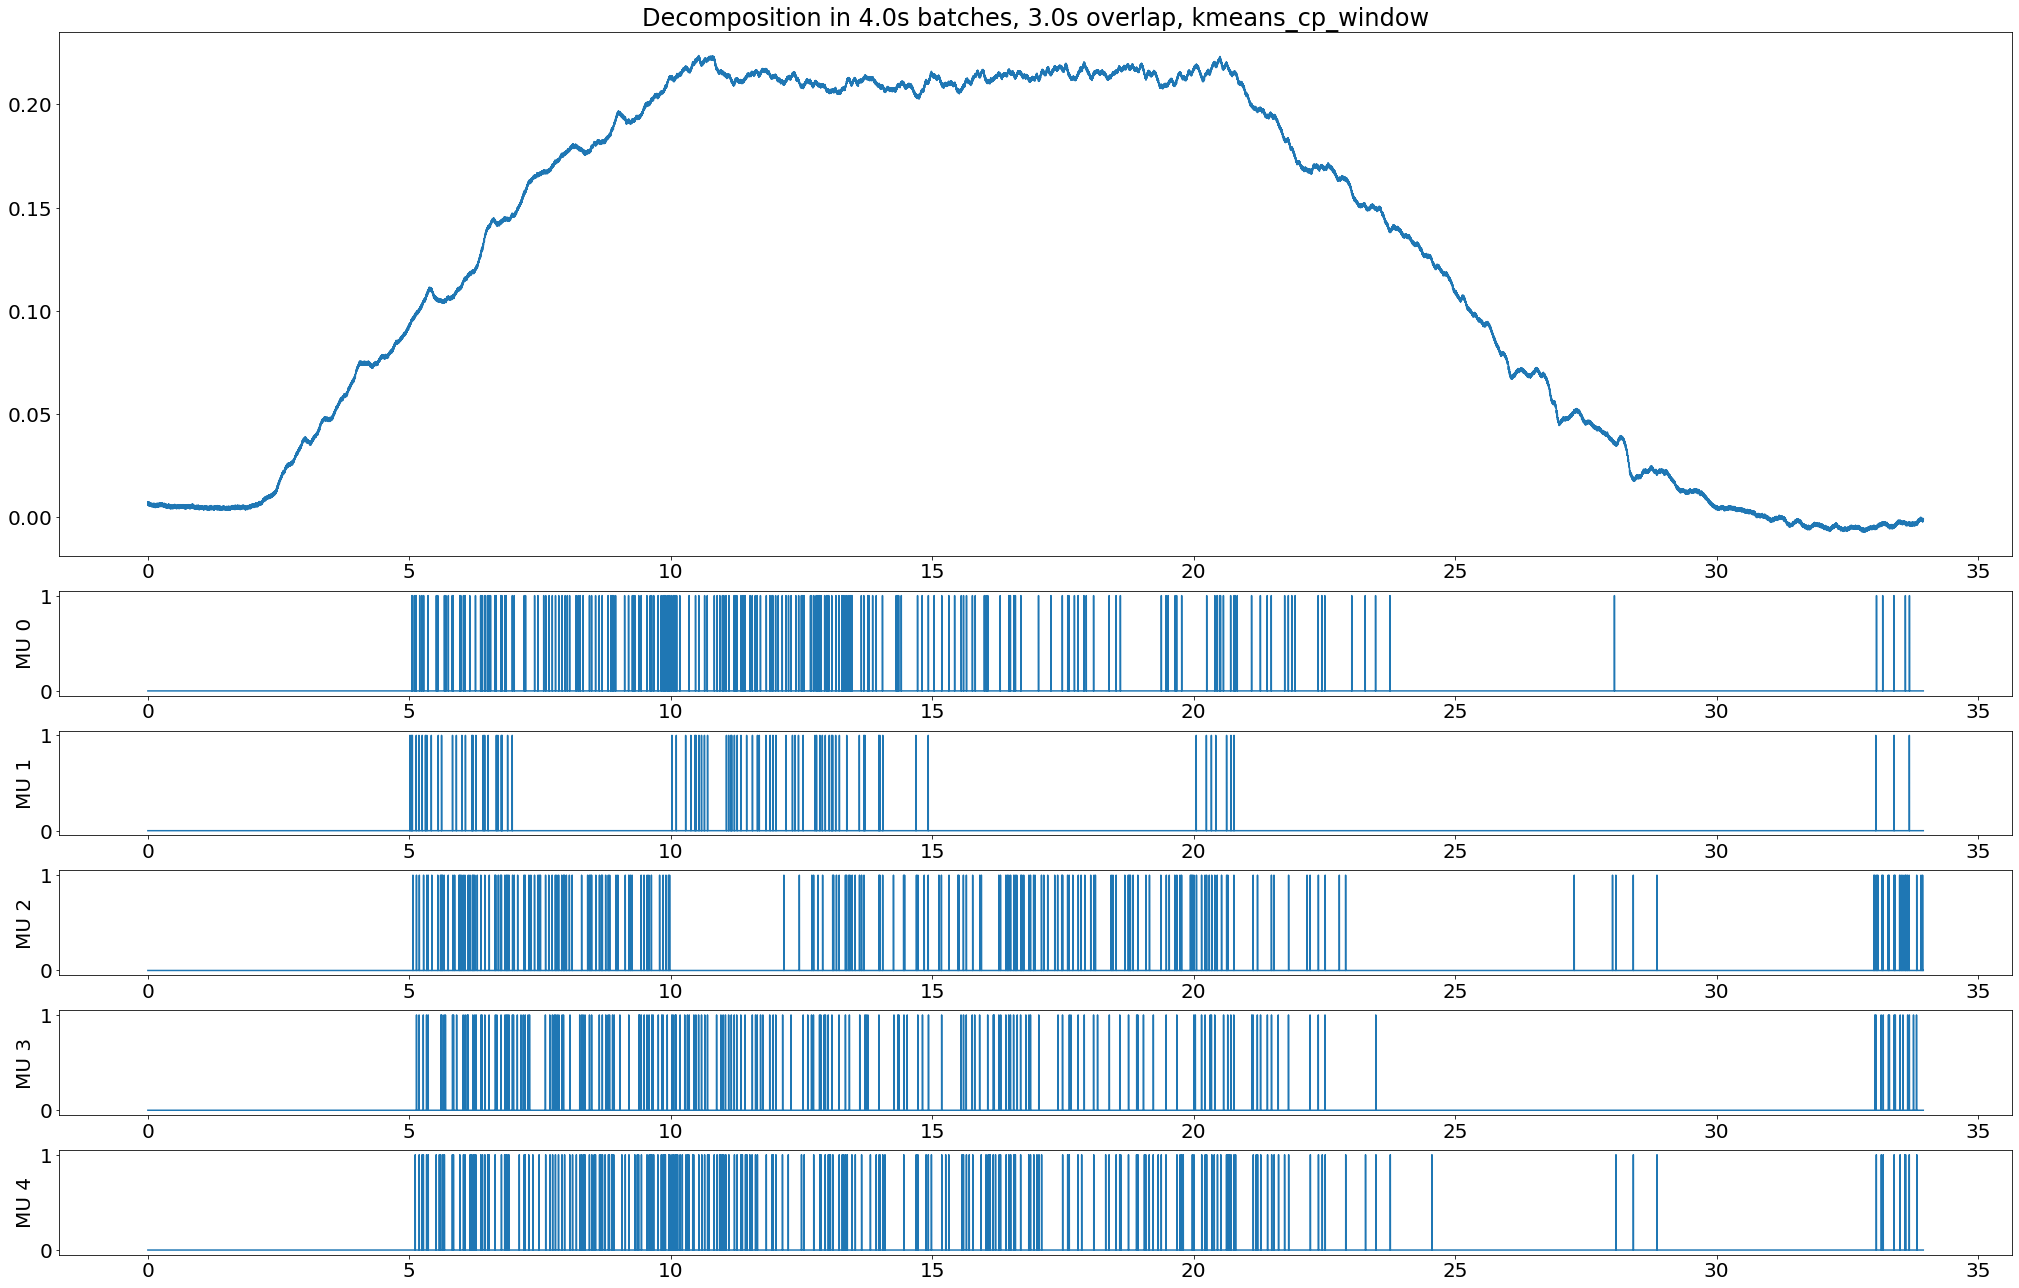

In [31]:
visualize_pt(kmeans_sil_cp_40_ol30["MUPulses"], 
             data, ref_signal=ref_signal,
             title=f"Decomposition in {batch_size}s batches, {ol[2]}s overlap, kmeans_cp_window")